# CONTEXT

**Company name:** Cardio Catch Disease.

**Product/Service:** The company offers a service that detects cardiovascular disease at early stages.

**Business Model:**
- The cost per diagnosis, is around BRL 1.000,00;
- The price that the custumer pays vary depending on the precision;
- For every 5% above 50% the custumer pays aditional BRL 500,00;
    - If the precision is 50% or below: Custumer does not pay;
    - If the precision is 55%: Custumer pays BRL 500,00;
    - If the precision is 60%: Custumer pays BRL 1.000,00, and so on.

**Current Situation:**
- The diagnosis are made manually by a team of specialists;
- The current precision is between **55% and 65%**.

**Problem:**
- The current precision is low to be profitable (sometimes the cost is higher than what is charged);
- The diagnosis takes some time to be ready due to be made manually.

**Proposed Solution:**
- Create a classification model that returns a better precision of the diagnosis and help the specialists on the diagnosis.

**Main questions to be answered:**
1. How much is the precision and accuracy ?
2. How much more profit Cardio Catch Diseases will make with the classification model?
3. How trustworthy is the result of the classification model?

# IMPORTS

In [1]:
# Data Manipulation
import numpy as np
import pandas as pd

# Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt
from scikitplot import metrics as mt

# Statistical Library
import statistics as st

# ignore warnings from the kernel
import warnings
warnings.filterwarnings( 'ignore' )

# Importing images to the kernel
from IPython.display import Image
%matplotlib inline

# Data Preparation (rescaling, transforming)
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split, StratifiedKFold

# Feature Selection
from boruta import BorutaPy
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

# Machine Learning Moddeling
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import cross_val_predict, cross_val_score, GridSearchCV
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier
import xgboost as xgb
import random

# ML Metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score, roc_auc_score, plot_confusion_matrix, roc_curve

# HELPER FUNCTIONS

In [2]:
############## DESCRIPTIVE STATISTIC ##############
def descriptive_stat(dataframe):

    # Central Tendency - mean, median, mode
    ct_mean = pd.DataFrame(dataframe.apply(np.mean)).T
    ct_median = pd.DataFrame(dataframe.apply(np.median)).T
    ct_mode = pd.DataFrame(dataframe.apply(st.mode)).T

    # Dispersion - std, min, max, range, skew, kurtosis
    dp_std = pd.DataFrame(dataframe.apply(np.std)).T
    dp_min = pd.DataFrame(dataframe.apply(min)).T
    dp_max = pd.DataFrame(dataframe.apply(max)).T
    dp_range = pd.DataFrame(dataframe.apply(lambda x: x.max() - x.min())).T
    dp_skew = pd.DataFrame(dataframe.apply(lambda x: x.skew())).T
    dp_kurtosis = pd.DataFrame(dataframe.apply(lambda x: x.kurtosis())).T

    # concatenate
    m = pd.concat([dp_min, dp_max, dp_range, ct_mean, ct_median, ct_mode, dp_std, dp_skew, dp_kurtosis]).T.reset_index()
    m.columns = (['attributes', 'min', 'max', 'range', 'mean', 'median', 'mode', 'std', 'skew','kurtosis'])

    return m

############## SETTING THEME OF GRAFS ##############
sns.set_theme()

# UNDERSTANDING BLOOD PRESSURE

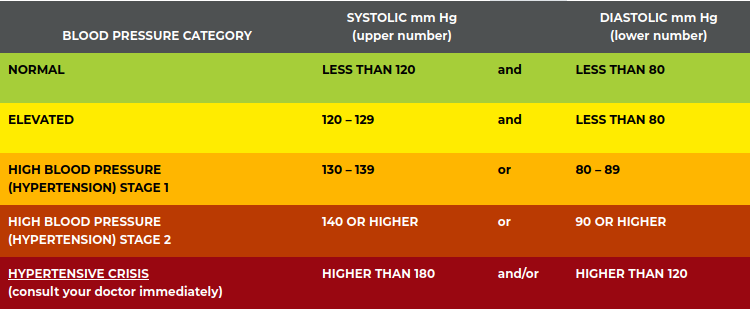

In [3]:
Image('/home/kazu/Repos/Cardio_Catch_Diseases/images/blood_pressure_table.png')

- Image source: https://www.heart.org/en/health-topics/high-blood-pressure/understanding-blood-pressure-readings

- **Systolic blood pressure (the first number)** – indicates how much pressure your blood is exerting against your artery walls when the heart beats.
- **Diastolic blood pressure (the second number)** – indicates how much pressure your blood is exerting against your artery walls while the heart is resting between beats.

**What about low blood pressure?**
- Low blood pressure is known as hypotension. In adults, a blood pressure reading of ***90/60 mm Hg*** or below is often considered hypotension. This can be dangerous because blood pressure that is too low doesn’t supply your body and heart with enough oxygenated blood.

source: https://www.healthline.com/health/high-blood-pressure-hypertension/blood-pressure-reading-explained#hypotension

# LOADING DATA

In [4]:
df_raw = pd.read_csv('data/cardio_train.csv', sep=';')

# 1.0. DATA DESCRIPTION

In [5]:
df1 = df_raw.copy()

In [6]:
df1.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


- Data Description source: https://www.kaggle.com/sulianova/cardiovascular-disease-dataset


- <b>There are 3 types of input features:</b>
    - Objective: factual information;
    - Examination: results of medical examination;
    - Subjective: information given by the patient.


- <b>Objective Features:</b>
    - Age (days);
    - Height (cm);
    - Weight (kg);
    - Gender (1 = women, 2 = men).
    
    
- <b>Examination Feature:</b>
    - Systolic blood pressure (ap_hi);
    - Diastolic blood pressure (ap_lo);
    - Cholesterol (1: normal, 2: above normal, 3: well above normal)
    - Glucose (1: normal, 2: above normal, 3: well above normal)
    
- <b>Subjective Feature:</b>
    - Smoking (binary);
    - Alcohol intake (binary);
    - Physical activity (binary);
    
    
- **Target Variable:**
    - Presence or absence of cardiovascular disease (binary)

All of the dataset values were collected at the moment of medical examination. 

## 1.1. Data Dimensions

In [7]:
print(f'Number of rows: {df1.shape[0]}')
print(f'Number of columns: {df1.shape[1]}')

Number of rows: 70000
Number of columns: 13


## 1.2. Rename Columns

In [8]:
df1.columns

Index(['id', 'age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo',
       'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio'],
      dtype='object')

In [9]:
# age -> age_days
# ap_hi -> systolic_bp
# ap_lo -> diastolic_bp

df1 = df1.rename(columns={'age': 'age_days', 'ap_hi': 'systolic_bp', 'ap_lo': 'diastolic_bp'})
df1.columns

Index(['id', 'age_days', 'gender', 'height', 'weight', 'systolic_bp',
       'diastolic_bp', 'cholesterol', 'gluc', 'smoke', 'alco', 'active',
       'cardio'],
      dtype='object')

## 1.3. Transform Age in Years

In [10]:
# Transforming Age in days to years.
df1['age_years'] = (df1['age_days'] / 365).astype(int)
df1.head()

,id,age_days,gender,height,weight,systolic_bp,diastolic_bp,cholesterol,gluc,smoke,alco,active,cardio,age_years
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0,50
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1,55
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1,51
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1,48
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0,47


## 1.4. Data Types

In [11]:
df1.dtypes

id                int64
age_days          int64
gender            int64
height            int64
weight          float64
systolic_bp       int64
diastolic_bp      int64
cholesterol       int64
gluc              int64
smoke             int64
alco              int64
active            int64
cardio            int64
age_years         int64
dtype: object

## 1.5. Check NA

In [12]:
df1.isna().sum()

id              0
age_days        0
gender          0
height          0
weight          0
systolic_bp     0
diastolic_bp    0
cholesterol     0
gluc            0
smoke           0
alco            0
active          0
cardio          0
age_years       0
dtype: int64

 - There is no NA in the Dataset

## 1.6. Descriptive Statistics

In [13]:
descriptive_stat(df1)

,attributes,min,max,range,mean,median,mode,std,skew,kurtosis
0,id,0.0,99999.0,99999.0,49972.419900,50001.5,0.0,28851.096242,-0.001278,-1.198374
1,age_days,10798.0,23713.0,12915.0,19468.865814,19703.0,19741.0,2467.234044,-0.307055,-0.823447
2,gender,1.0,2.0,1.0,1.349571,1.0,1.0,0.476835,0.630960,-1.601935
3,height,55.0,250.0,195.0,164.359229,165.0,165.0,8.210068,-0.642187,7.943653
4,weight,10.0,200.0,190.0,74.205690,72.0,65.0,14.395654,1.012070,2.586825
5,systolic_bp,-150.0,16020.0,16170.0,128.817286,120.0,120.0,154.010319,85.296214,7580.074738
6,diastolic_bp,-70.0,11000.0,11070.0,96.630414,80.0,80.0,188.471184,32.114083,1425.914585
7,cholesterol,1.0,3.0,2.0,1.366871,1.0,1.0,0.680245,1.587123,0.993901
8,gluc,1.0,3.0,2.0,1.226457,1.0,1.0,0.572266,2.397462,4.294377
9,smoke,0.0,1.0,1.0,0.088129,0.0,0.0,0.283482,2.905867,6.444250


- **Key takeaways:**
    - Minimum height of 55.0 and maximum of 250.0;
    - Minimum weight of 10.0 and maximum of 200.0;
    - Minimum systolic_bp of -150.0 and maximum of 16,020;
    - Minimum diastolic_bp of -70.0 and maximum of 11,000;
    - There are more women than man in the dataset;
    - Most people have normal (1) cholesterol level;
    - Most people have normal (1) glucose level;
    - Most people do not smoke (0);
    - Most people is active (1);
    - Most people does not have cardiovascular disease (0);

## 1.7. Checking Outliers

### 1.7.1. Blood Pressure

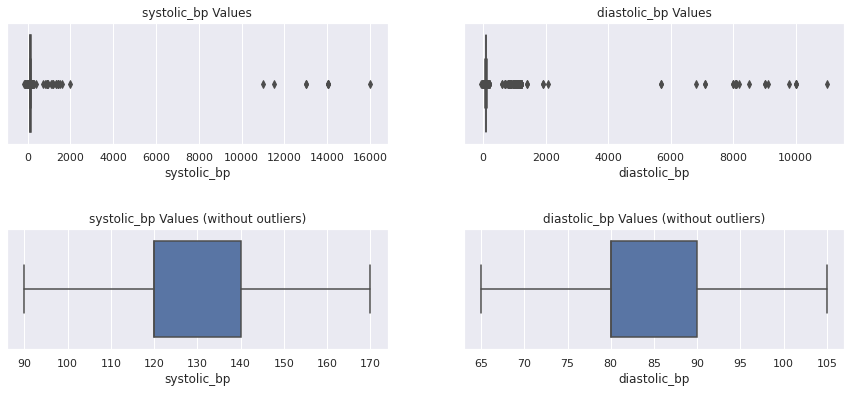

In [14]:
# Visualizing blood pressure (systolic_bp and diastolic_bp)
plt.figure(figsize=(15, 6));
plt.subplots_adjust(hspace=0.7);

# Boxplot with outliers
plt.subplot(2, 2, 1);
sns. boxplot(df1['systolic_bp']);
plt.title('systolic_bp Values');

plt.subplot(2, 2, 2);
sns. boxplot(df1['diastolic_bp']);
plt.title('diastolic_bp Values');

# Boxplot without outliers
plt.subplot(2, 2, 3);
sns. boxplot(df1['systolic_bp'], showfliers=False);
plt.title('systolic_bp Values (without outliers)');

plt.subplot(2, 2, 4);
sns. boxplot(df1['diastolic_bp'], showfliers=False);
plt.title('diastolic_bp Values (without outliers)');


In [15]:
# systolic_bp Quantiles (Q1, Q3 and IQR) and threshold for outliers (lower_th and upper_th)
Q1 = df1['systolic_bp'].quantile(0.25)
Q3 = df1['systolic_bp'].quantile(0.75)
IQR = Q3 - Q1

lower_th = Q1 - (IQR * 1.5)
upper_th = Q3 + (IQR * 1.5)
print('systolic_bp:')
print(f'Q1: {Q1}\nQ3: {Q3}\nlower_th: {lower_th}\nupper_th: {upper_th}')

# diastolic_bp Quantiles (Q1, Q3 and IQR) and threshold for outliers (lower_th and upper_th)
Q1 = df1['diastolic_bp'].quantile(0.25)
Q3 = df1['diastolic_bp'].quantile(0.75)
IQR = Q3 - Q1

lower_th = Q1 - (IQR * 1.5)
upper_th = Q3 + (IQR * 1.5)
print('\ndiastolic_bp:')
print(f'Q1: {Q1}\nQ3: {Q3}\nlower_th: {lower_th}\nupper_th: {upper_th}')

systolic_bp:
Q1: 120.0
Q3: 140.0
lower_th: 90.0
upper_th: 170.0

diastolic_bp:
Q1: 80.0
Q3: 90.0
lower_th: 65.0
upper_th: 105.0


If we were to look only at a statistical standpoint, we would consider everything below 90/65 mm Hg and everything higher 170/105 mm Hg as outliers.

But as we saw in **Understanding Blood Pressure** section, it is possible to have those blood pressure values.
So we will consider outliers in a clinical standpoint, as follows:
- **systolic_bp**: below 90 and higher than 200;
- **diastolic_bp**: below 60 and higher than 140.

In [16]:
# Selecting Blood Pressure Outliers
bp_outliers = df1[(df1['systolic_bp'] < 90) | (df1['systolic_bp'] > 200) |
                  (df1['diastolic_bp'] < 60) | (df1['diastolic_bp'] > 140)]
bp_outliers.shape

(1534, 14)

### 1.7.2. Height and Weight

<AxesSubplot:xlabel='weight', ylabel='height'>

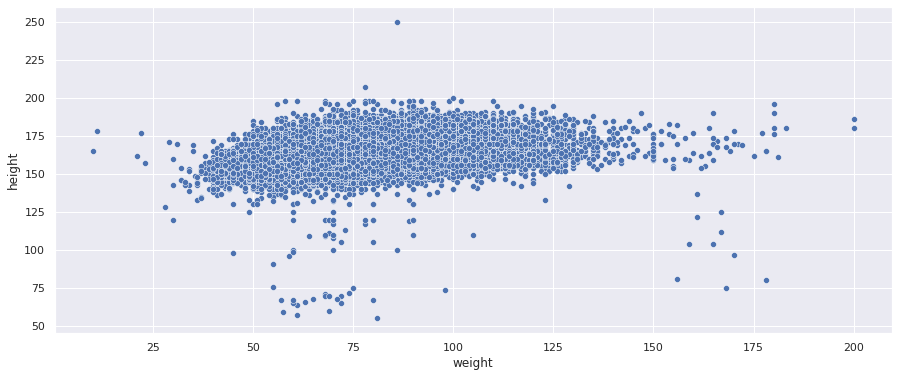

In [17]:
plt.figure(figsize=(15, 6));
sns.scatterplot(x=df1['weight'], y=df1['height'])

To have a better understand, I'm going to calculate the IMC (Índice de Massa Corporal).

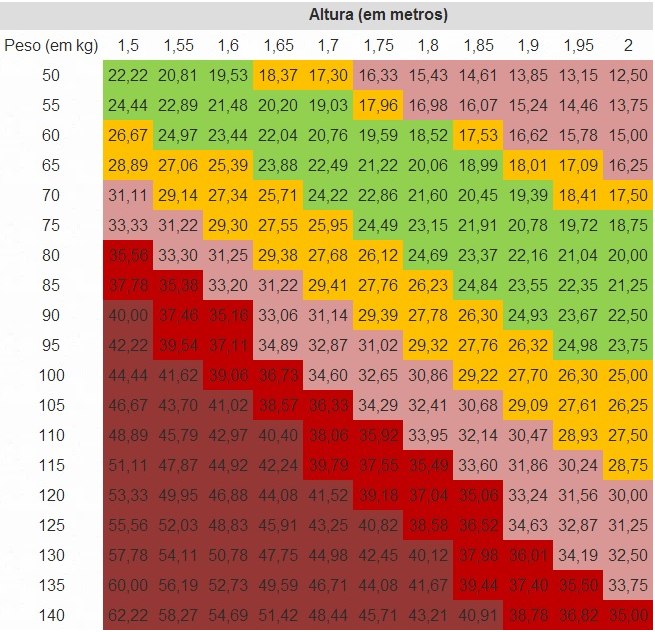

In [18]:
Image('/home/kazu/Repos/Cardio_Catch_Diseases/images/IMC_table.png')

Image source: https://ipgo.com.br/indice-de-massa-corporea/

According to this source there are 5 ranges, which are:
- From 18 to 20 - underweight;
- From 20 to 25 - healthy;
- From 25 to 30 - overweight;
- From 30 to 40 - obese;
- Greater than 40 - extreme obese.

We are going to assume as outliers, IMC values that are smaller than 14.0 and greater than 50.0.

In [19]:
# calculating IMC
df1['IMC'] = df1['weight'] / (df1['height'] / 100)**2
df1['IMC']

0        21.967120
1        34.927679
2        23.507805
3        28.710479
4        23.011177
           ...    
69995    26.927438
69996    50.472681
69997    31.353579
69998    27.099251
69999    24.913495
Name: IMC, Length: 70000, dtype: float64

In [20]:
# Selecting IMC Outliers
IMC_outliers = df1[(df1['IMC'] < 14.0) | (df1['IMC'] > 50.0)]
IMC_outliers.describe()

,id,age_days,gender,height,weight,systolic_bp,diastolic_bp,cholesterol,gluc,smoke,alco,active,cardio,age_years,IMC
count,257.000000,257.000000,257.000000,257.000000,257.000000,257.000000,257.000000,257.000000,257.000000,257.000000,257.000000,257.000000,257.000000,257.000000,257.000000
mean,49639.922179,19653.579767,1.237354,140.848249,116.021790,135.027237,114.821012,1.525292,1.428016,0.054475,0.050584,0.805447,0.645914,53.342412,66.218903
std,29731.494525,2420.073761,0.426291,31.878620,39.987812,22.829943,164.115715,0.775820,0.736648,0.227395,0.219574,0.396628,0.479168,6.634977,40.763946
min,309.000000,14396.000000,1.000000,55.000000,10.000000,12.000000,8.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,39.000000,3.471784
25%,23402.000000,18235.000000,1.000000,120.000000,80.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,49.000000,51.929084
50%,49024.000000,19868.000000,1.000000,154.000000,125.000000,130.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,54.000000,55.555556
75%,76041.000000,21400.000000,1.000000,162.000000,146.000000,150.000000,90.000000,2.000000,2.000000,0.000000,0.000000,1.000000,1.000000,58.000000,60.221981
max,99995.000000,23646.000000,2.000000,250.000000,200.000000,220.000000,1100.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000,64.000000,298.666667


### 1.7.3. Removing Outliers

- **To summarize the outliers are**:
    - **systolic_bp**: below 90 and higher than 200
    - **diastolic_bp**: below 60 and higher than 140
    - **IMC**: below 14.0 and higher than 50.0.

In [21]:
df1.shape

(70000, 15)

In [22]:
# Removing Outliers from the Dataset
df1_wo_outliers = df1[~((df1['systolic_bp'] < 90) | (df1['systolic_bp'] > 200) |
                        (df1['diastolic_bp'] < 60) | (df1['diastolic_bp'] > 140) |
                        (df1['IMC'] < 14.0) | (df1['IMC'] > 50.0))]
df1_wo_outliers.shape[0]

68220

In [23]:
# Percentage of data removed
aux1 = df1.shape[0] - df1_wo_outliers.shape[0]
aux2 = round(((df1.shape[0] - df1_wo_outliers.shape[0]) / df1.shape[0]) * 100, 2)

print(f'Number of rows removed: {aux1}\nPercentage of data removed: {aux2}%')

Number of rows removed: 1780
Percentage of data removed: 2.54%


As we can see, it was removed 1780 rows, which represents 2.54% of the dataset.

## 1.8. Descriptive Statistics Without Outliers

In [24]:
# Descriptive Statistics without outliers
descriptive_stat(df1_wo_outliers)

,attributes,min,max,range,mean,median,mode,std,skew,kurtosis
0,id,0.0000,99999.0,99999.0000,49973.054617,50009.500000,0.000000,28843.366814,-0.001101,-1.197867
1,age_days,10798.0000,23713.0,12915.0000,19464.879214,19701.000000,19741.000000,2467.604294,-0.305245,-0.824845
2,gender,1.0000,2.0,1.0000,1.349252,1.000000,1.000000,0.476734,0.632432,-1.600077
3,height,120.0000,207.0,87.0000,164.452785,165.000000,165.000000,7.845876,0.101585,0.258050
4,weight,28.0000,180.0,152.0000,73.985094,72.000000,65.000000,13.920760,0.806721,1.232115
5,systolic_bp,90.0000,200.0,110.0000,126.627792,120.000000,120.000000,16.400130,0.869146,1.288052
6,diastolic_bp,60.0000,140.0,80.0000,81.344547,80.000000,80.000000,9.311285,0.375614,1.553230
7,cholesterol,1.0000,3.0,2.0000,1.363867,1.000000,1.000000,0.678487,1.600255,1.036286
8,gluc,1.0000,3.0,2.0000,1.225007,1.000000,1.000000,0.570969,2.409190,4.350782
9,smoke,0.0000,1.0,1.0000,0.088009,0.000000,0.000000,0.283309,2.908488,6.459489


<AxesSubplot:xlabel='weight', ylabel='height'>

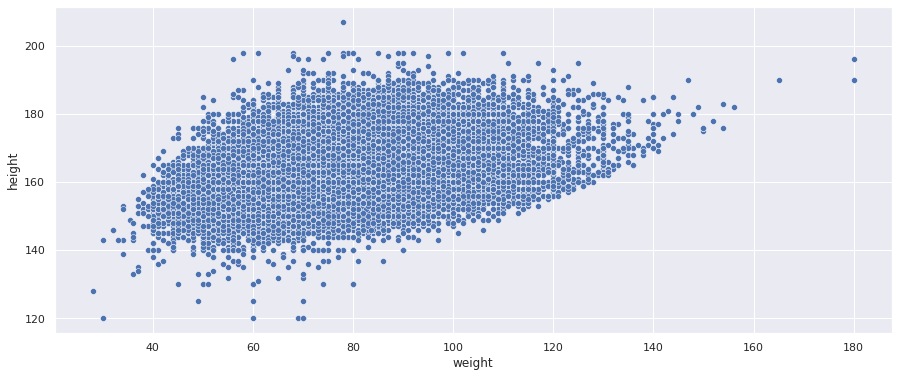

In [25]:
plt.figure(figsize=(15, 6));
sns.scatterplot(x=df1_wo_outliers['weight'], y=df1_wo_outliers['height'])

# 2.0. FEATURE ENGINEERING

In [26]:
df2 = df1_wo_outliers.copy()

## 2.1. Mind Map Hypotesis

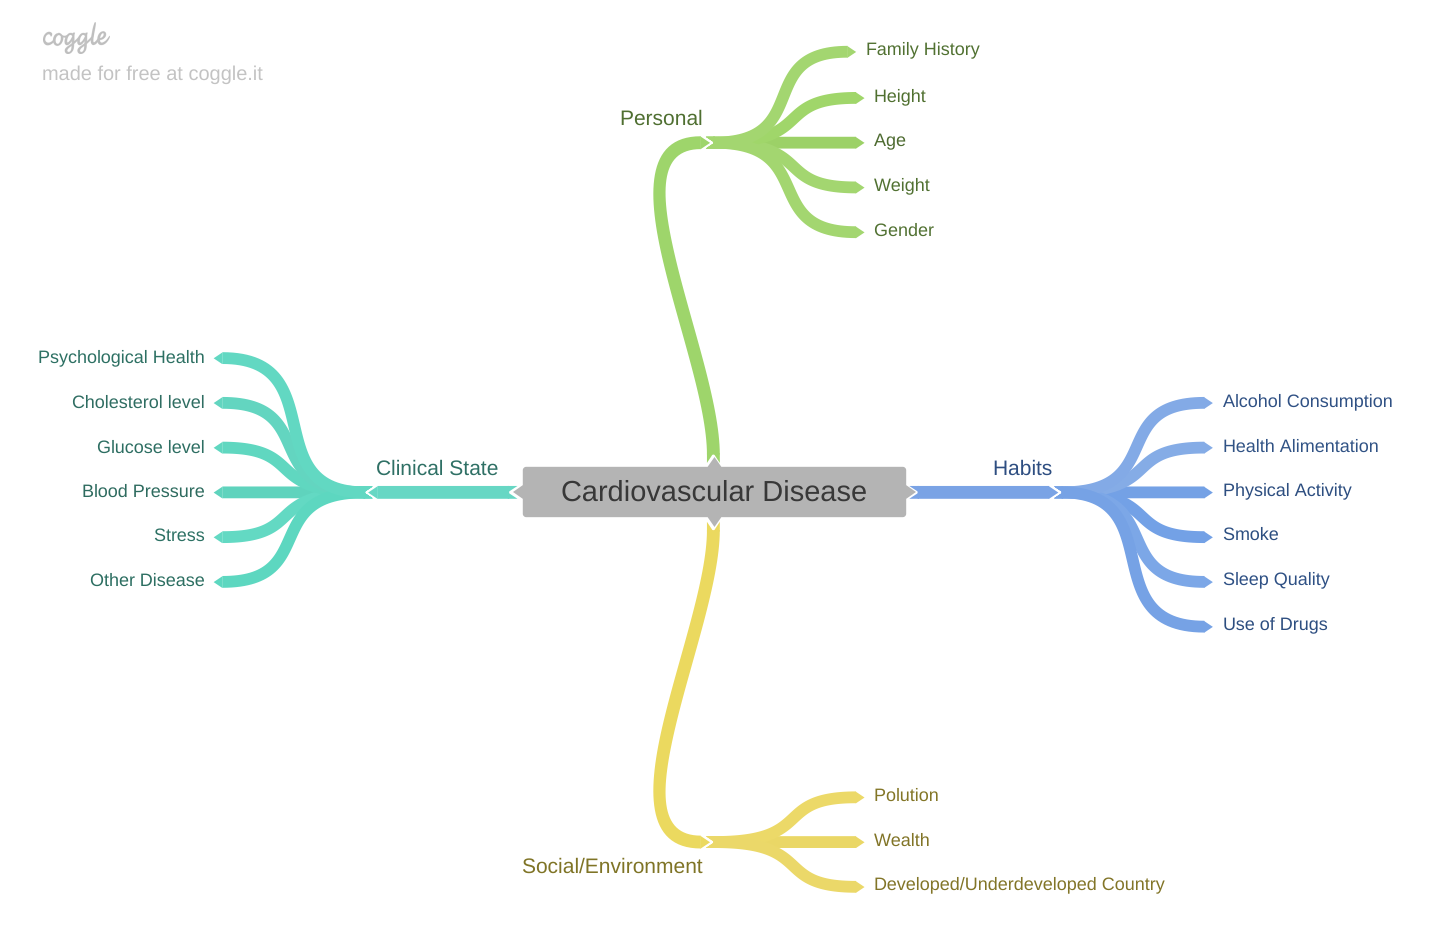

In [27]:
Image('/home/kazu/Repos/Cardio_Catch_Diseases/images/Mind_Map_Hypotesis.png')

## 2.2. Hypothesis Creation

### 2.2.1. Habits Hypothesis

**1.** There are more cases of cardiovascular disease in patients that drinks alcohol;

**2.** There are more cases of cardiovascular disease in patients that doesn't have health eating habit.

**3.** There are more cases of cardiovascular disease in patients that doesn't practice physical activity.

**4.** There are more cases of cardiovascular disease in patients that smokes;

**5.** There are more cases of cardiovascular disease in patients that doens't have a good sleep quality;

**6.** There are more cases of cardiovascular disease in patients that uses drugs.

### 2.2.2. Social/Environment Hypothesis

**1.** There are more cases of cardiovascular disease in patients that lives in poluted cities;

**2.** There are more cases of cardiovascular disease in patients that are not wealth;

**3.** There are more cases of cardiovascular disease in patients that lives in underdeveloped countries.

### 2.2.3. Clinical Status Hypothesis

**1.** There are more cases of cardiovascular disease in patients that is not psycologic health;

**2.** There are more cases of cardiovascular disease in patients that has well above normal cholesterol level;

**3.** There are more cases of cardiovascular disease in patients that has well above normal glucose level;

**4.** There are more cases of cardiovascular disease in patients that has higher systolic blood pressure;

**5.** There are more cases of cardiovascular disease in patients that has higher diastolic blood pressure;

**6.** There are more cases of cardiovascular disease in patients that has high blood pressure;

**7.** There are more cases of cardiovascular disease in patients that is stressed;

**8.** There are more cases of cardiovascular disease in patients that previusly has other diseases.

### 2.2.4. Personal Hypothesis

**1.** There are more cases of cardiovascular disease in patients that has cardiovascular disease in family history;

**2.** There are more cases of cardiovascular disease in patients that are taller;

**3.** There are more cases of cardiovascular disease in patients that are older;

**4.** There are more cases of cardiovascular disease in patients that weights more;

**5.** There are more cases of cardiovascular disease in patients that are male.

### 2.2.5. Final Hypothesis List

**1.** There are more cases of cardiovascular disease in patients that drinks alcohol;

**2.** There are more cases of cardiovascular disease in patients that doesn't practice physical activity;

**3.** There are more cases of cardiovascular disease in patients that smokes;

**4.** There are more cases of cardiovascular disease in patients that has well above normal cholesterol level;

**5.** There are more cases of cardiovascular disease in patients that has well above normal glucose level;

**6.** There are more cases of cardiovascular disease in patients that has higher systolic blood pressure;

**7.** There are more cases of cardiovascular disease in patients that has higher diastolic blood pressure;

**8.** There are more cases of cardiovascular disease in patients that are taller;

**9.** There are more cases of cardiovascular disease in patients that are older;

**10.** There are more cases of cardiovascular disease in patients that weights more;

**11.** There are more cases of cardiovascular disease in patients that are male.

## 2.3. Feature Engineering

In [28]:
# Blood Pressure Classification
df2['bp_class'] = ['normal' if (systolic_bp < 120) & (diastolic_bp < 80)
                            else 'elevated' if ((systolic_bp >= 120) & (systolic_bp <= 129)) & (diastolic_bp < 80)
                            else 'hypertension 1' if ((systolic_bp >= 130) & (systolic_bp <= 139)) | ((diastolic_bp >= 80) & (diastolic_bp <=89))
                            else 'hypertension 2' if (systolic_bp >= 140) | (systolic_bp >= 90)
                            else 'hypertensive crisis'
                            for systolic_bp, diastolic_bp in zip(df2['systolic_bp'], df2['diastolic_bp'])]

# IMC Classification
df2['IMC_class'] = df2['IMC'].apply(lambda x: 'underweight' if x <= 20
                                   else 'health' if x < 25
                                   else 'overweight' if x < 30
                                   else 'obese' if x < 40
                                   else 'extreme obese')
# Rearrenge columns
df2 = df2[['id', 'age_days', 'age_years', 'gender', 'height', 'weight', 'IMC', 'IMC_class', 'systolic_bp',
       'diastolic_bp', 'bp_class', 'cholesterol', 'gluc', 'smoke', 'alco', 'active',
       'cardio', ]]

df2.head(10)

,id,age_days,age_years,gender,height,weight,IMC,IMC_class,systolic_bp,diastolic_bp,bp_class,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,50,2,168,62.0,21.967120,health,110,80,hypertension 1,1,1,0,0,1,0
1,1,20228,55,1,156,85.0,34.927679,obese,140,90,hypertension 2,3,1,0,0,1,1
2,2,18857,51,1,165,64.0,23.507805,health,130,70,hypertension 1,3,1,0,0,0,1
3,3,17623,48,2,169,82.0,28.710479,overweight,150,100,hypertension 2,1,1,0,0,1,1
4,4,17474,47,1,156,56.0,23.011177,health,100,60,normal,1,1,0,0,0,0
5,8,21914,60,1,151,67.0,29.384676,overweight,120,80,hypertension 1,2,2,0,0,0,0
6,9,22113,60,1,157,93.0,37.729725,obese,130,80,hypertension 1,3,1,0,0,1,0
7,12,22584,61,2,178,95.0,29.983588,overweight,130,90,hypertension 1,3,3,0,0,1,1
8,13,17668,48,1,158,71.0,28.440955,overweight,110,70,normal,1,1,0,0,1,0
9,14,19834,54,1,164,68.0,25.282570,overweight,110,60,normal,1,1,0,0,0,0


# 3.0. EXPLORATORY DATA ANALYSIS

In [29]:
df3 = df2.copy()

## 3.1. Separating Numerical and Categorical Variables

In [30]:
# Selecting numerical variables
num_var = df3[['age_days','age_years','height', 'weight', 'IMC', 'systolic_bp', 'diastolic_bp']]

# Selecting categorical variables
cat_var = df3[['gender', 'IMC_class', 'bp_class', 'cholesterol', 'gluc', 'smoke','alco', 'active']]

## 3.2. Univariate Analysis

### 3.2.1. Count Target Variable

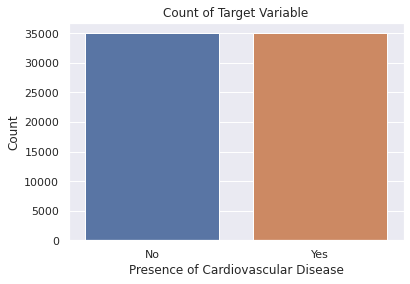

In [31]:
sns.countplot(df1['cardio']);
plt.title('Count of Target Variable');
plt.xlabel('Presence of Cardiovascular Disease');
plt.ylabel('Count');
plt.xticks(ticks=[0,1], labels=['No','Yes']);

In [32]:
# Distribution of Cardiovascular Disease in Dataset (Absolute Number)
cardio_1 = ((df3['cardio']) == 1).sum()
cardio_0 = ((df3['cardio']) == 0).sum()
print(f'Number of patients without cardiovascular disease: {cardio_0}')
print(f'Number of patients with cardiovascular disease: {cardio_1}')

# Distribution of Cardiovascular Disease in Dataset in Percentage
cardio_0_perc = round(((cardio_0 / (cardio_1 + cardio_0)) * 100), 2)
cardio_1_perc = round(((cardio_1 / (cardio_1 + cardio_0)) * 100), 2)
print(f'\nPercentage of patientes without cardiovascular disease: {cardio_0_perc}%')
print(f'Percentage of patientes with cardiovascular disease: {cardio_1_perc}%')

Number of patients without cardiovascular disease: 34483
Number of patients with cardiovascular disease: 33737

Percentage of patientes without cardiovascular disease: 50.55%
Percentage of patientes with cardiovascular disease: 49.45%


The data is well balanced, having almost 50% of each category.

### 3.2.2. Numercial Variables

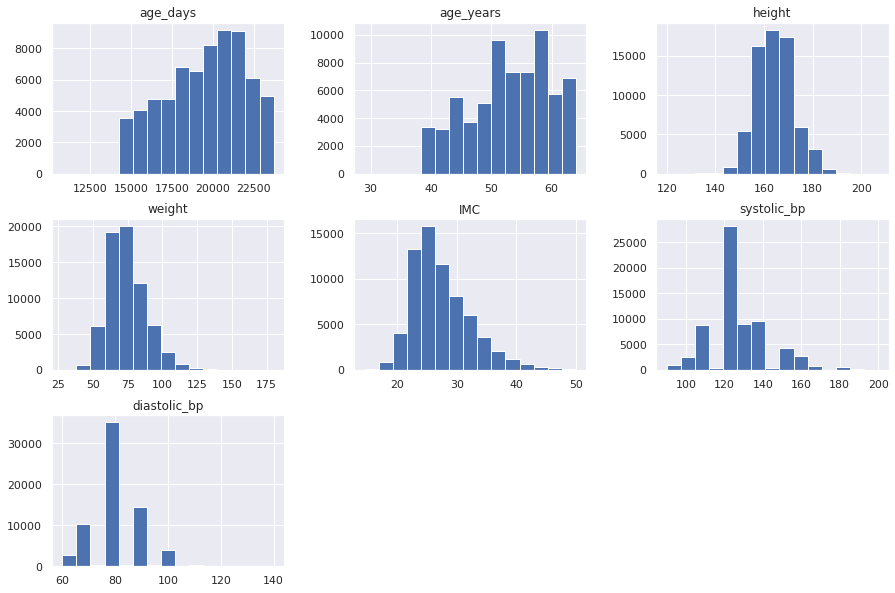

In [33]:
num_var.hist(bins=15, figsize=(15, 10));

**The majority of the patients has:**
- 50-60 years old;
- 160-170 cm height;
- Weights 60-90 kg;
- IMC of 20-30;
- Systolic Blood Pressure of 120;
- Diastolic Blood Pressure of 80.

### 3.2.3. Categorical Variables

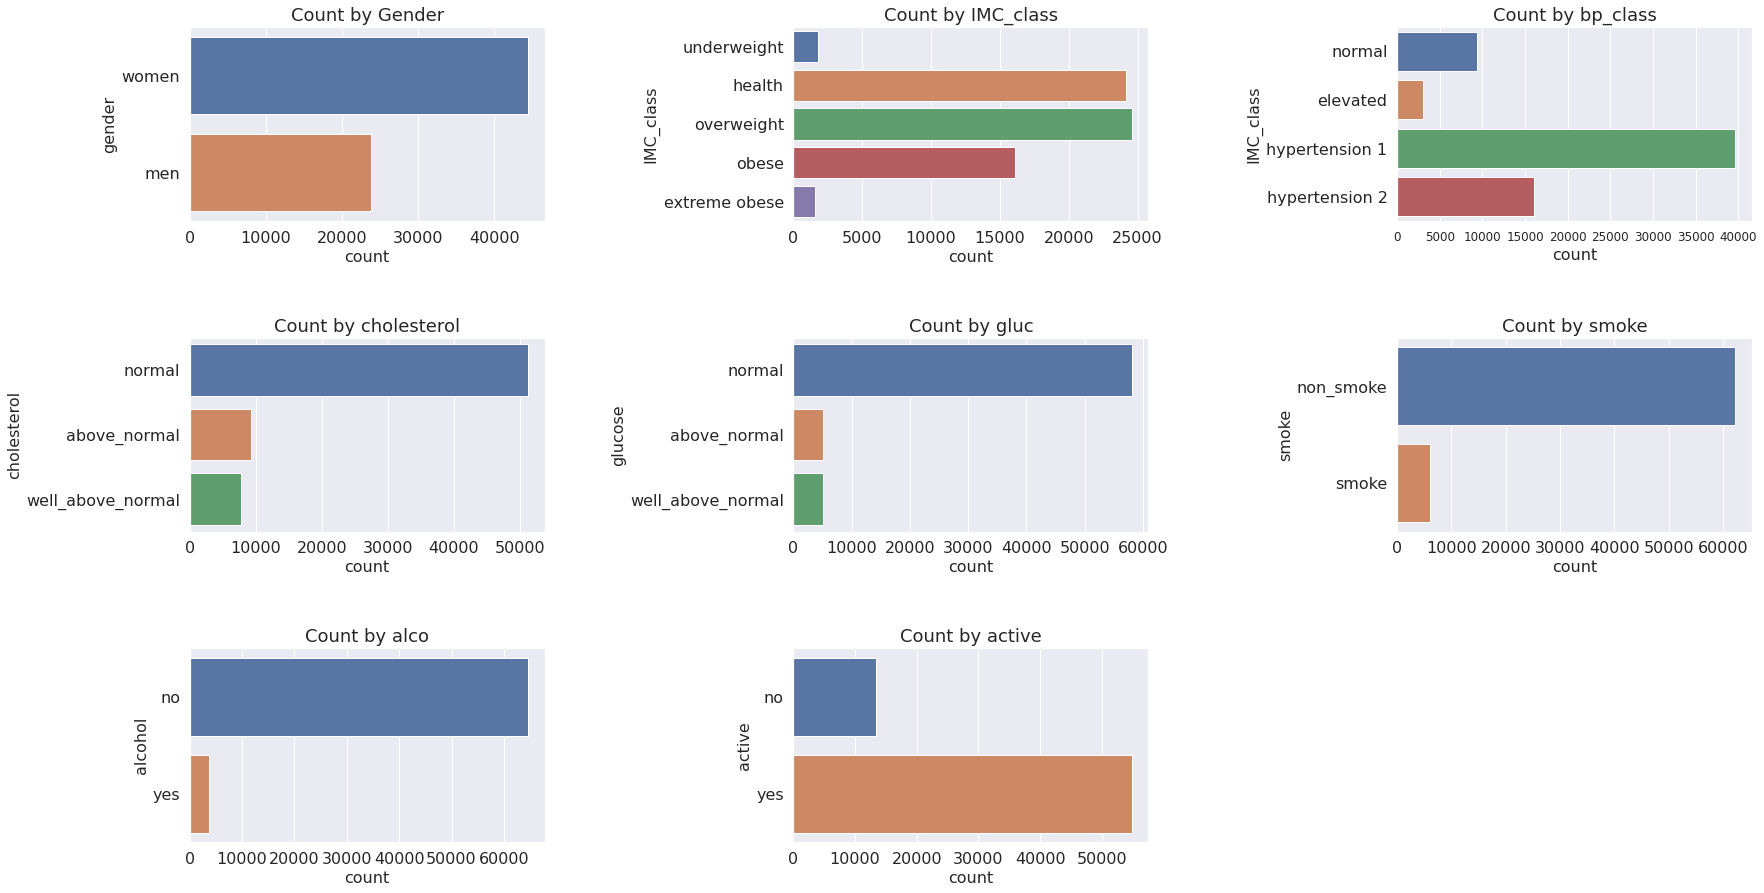

In [34]:
plt.figure(figsize=(28, 15));
plt.subplots_adjust(wspace=0.7, hspace=0.6);

# gender
plt.subplot(3, 3, 1)
sns.countplot(y=cat_var['gender']);
plt.title('Count by Gender', fontsize=18);
plt.xlabel('count', fontsize=16)
plt.ylabel('gender', fontsize=16)
plt.yticks(ticks=[0, 1], labels=['women', 'men'], fontsize=16);
plt.xticks(fontsize=16);


# IMC_class
plt.subplot(3, 3, 2)
sns.countplot(y=cat_var['IMC_class'], order=['underweight', 'health', 'overweight', 'obese', 'extreme obese']);
plt.title('Count by IMC_class', fontsize=18);
plt.xlabel('count', fontsize=16)
plt.ylabel('IMC_class', fontsize=16)
plt.xticks(fontsize=16);
plt.yticks(fontsize=16);

# bp_class
plt.subplot(3, 3, 3)
sns.countplot(y=cat_var['bp_class'], order=['normal', 'elevated', 'hypertension 1', 'hypertension 2']);
plt.title('Count by bp_class', fontsize=18);
plt.xlabel('count', fontsize=16)
plt.ylabel('IMC_class', fontsize=16)
plt.xticks(fontsize=12);
plt.yticks(fontsize=16);


# cholesterol
plt.subplot(3, 3, 4)
sns.countplot(y=cat_var['cholesterol']);
plt.title('Count by cholesterol', fontsize=18);
plt.xlabel('count', fontsize=16)
plt.ylabel('cholesterol', fontsize=16)
plt.xticks(fontsize=16);
plt.yticks(ticks=[0, 1, 2], labels=['normal', 'above_normal', 'well_above_normal'], fontsize=16);


# gluc
plt.subplot(3, 3, 5)
sns.countplot(y=cat_var['gluc']);
plt.title('Count by gluc', fontsize=18);
plt.xlabel('count', fontsize=16)
plt.ylabel('glucose', fontsize=16)
plt.xticks(fontsize=16);
plt.yticks(ticks=[0, 1, 2], labels=['normal', 'above_normal', 'well_above_normal'], fontsize=16);

# smoke
plt.subplot(3, 3, 6)
sns.countplot(y=cat_var['smoke']);
plt.title('Count by smoke', fontsize=18);
plt.ylabel('smoke', fontsize=16)
plt.xlabel('count', fontsize=16)
plt.yticks(ticks=[0, 1], labels=['non_smoke', 'smoke'], fontsize=16);
plt.xticks(fontsize=16);

# alco
plt.subplot(3, 3, 7)
sns.countplot(y=cat_var['alco']);
plt.title('Count by alco', fontsize=18);
plt.ylabel('alcohol', fontsize=16)
plt.xlabel('count', fontsize=16)
plt.yticks(ticks=[0, 1], labels=['no', 'yes'], fontsize=16);
plt.xticks(fontsize=16);

# active
plt.subplot(3, 3, 8)
sns.countplot(y=cat_var['active']);
plt.title('Count by active', fontsize=18);
plt.ylabel('active', fontsize=16)
plt.xlabel('count', fontsize=16)
plt.yticks(ticks=[0, 1], labels=['no', 'yes'], fontsize=16);
plt.xticks(fontsize=16);

In [35]:
# gender
gender_counts = pd.DataFrame(cat_var['gender'].value_counts())
gender_counts['%'] = ((gender_counts.apply(lambda x: x / x.sum()))*100).round(2)
gender_counts.rename(columns={'gender': 'count'}, index={1: 'women', 2: 'men'}, inplace=True)

# IMC_class
IMC_class_counts = pd.DataFrame(cat_var['IMC_class'].value_counts())
IMC_class_counts['%'] = ((IMC_class_counts.apply(lambda x: x / x.sum()))*100).round(2)
IMC_class_counts.rename(columns={'IMC_class': 'count'}, inplace=True)

# bp_class
bp_class_counts = pd.DataFrame(cat_var['bp_class'].value_counts())
bp_class_counts['%'] = ((bp_class_counts.apply(lambda x: x / x.sum()))*100).round(2)
bp_class_counts.rename(columns={'bp_class': 'count'}, inplace=True)

# cholesterol
cholesterol_counts = pd.DataFrame(cat_var['cholesterol'].value_counts())
cholesterol_counts['%'] = ((cholesterol_counts.apply(lambda x: x / x.sum()))*100).round(2)
cholesterol_counts.rename(index={1: 'normal', 2: 'above normal', 3: 'well above normal'},
                          columns={'cholesterol': 'count'}, inplace=True)

# gluc
gluc_counts = pd.DataFrame(cat_var['gluc'].value_counts())
gluc_counts['%'] = ((gluc_counts.apply(lambda x: x / x.sum()))*100).round(2)
gluc_counts.rename(index={1: 'normal', 2: 'above normal', 3: 'well above normal'},
                   columns={'gluc': 'count'}, inplace=True)


# smoke
smoke_counts = pd.DataFrame(cat_var['smoke'].value_counts())
smoke_counts['%'] = ((smoke_counts.apply(lambda x: x / x.sum()))*100).round(2)
smoke_counts.rename(index={0: 'no', 1: 'yes'},
                    columns={'smoke': 'count'}, inplace=True)


# alco
alco_counts = pd.DataFrame(cat_var['alco'].value_counts())
alco_counts['%'] = ((alco_counts.apply(lambda x: x / x.sum()))*100).round(2)
alco_counts.rename(index={0: 'no', 1: 'yes'},
                   columns={'alco': 'count'}, inplace=True)

# active
active_counts = pd.DataFrame(cat_var['active'].value_counts())
active_counts['%'] = ((active_counts.apply(lambda x: x / x.sum()))*100).round(2)
active_counts.rename(index={0: 'no', 1: 'yes'},
                     columns={'active': 'count'}, inplace=True)

# concatenate
frames = [gender_counts,
          IMC_class_counts,
          bp_class_counts,
          cholesterol_counts,
          gluc_counts,
          smoke_counts,
          alco_counts,
          active_counts]

result = pd.concat(frames, keys=['gender',
                                 'IMC_class',
                                 'bp_class',
                                 'cholesterol',
                                 'glucose',
                                 'smoke',
                                 'alcohol',
                                 'active'])

result

count      %
gender      women              44394  65.07
            men                23826  34.93
IMC_class   overweight         24563  36.01
            health             24144  35.39
            obese              16134  23.65
            underweight         1807   2.65
            extreme obese       1572   2.30
bp_class    hypertension 1     39637  58.10
            hypertension 2     16089  23.58
            normal              9398  13.78
            elevated            3096   4.54
cholesterol normal             51204  75.06
            above normal        9209  13.50
            well above normal   7807  11.44
glucose     normal             58042  85.08
            well above normal   5172   7.58
            above normal        5006   7.34
smoke       no                 62216  91.20
            yes                 6004   8.80
alcohol     no                 64575  94.66
            yes                 3645   5.34
active      yes                54813  80.35
            no                 13407  19.65

**Most of the patients**:
- Is Women (65.07%);
- Is classified as Health (35.39%) and overweight (36.01%) by IMC;
- Has Hypertension 1 (58.1%);
- Has normal cholesterol level (75.06%);
- Has normal Glucose level (85.08%);
- Is Non Smoking (91.2%);
- Does not drink alcohol (94.66%);
- Practice physical activity (80,35%).

## 3.3. Bivariate Analysis

**H1. There are more cases of cardiovascular disease in patients that drinks alcohol.**

**FALSE**

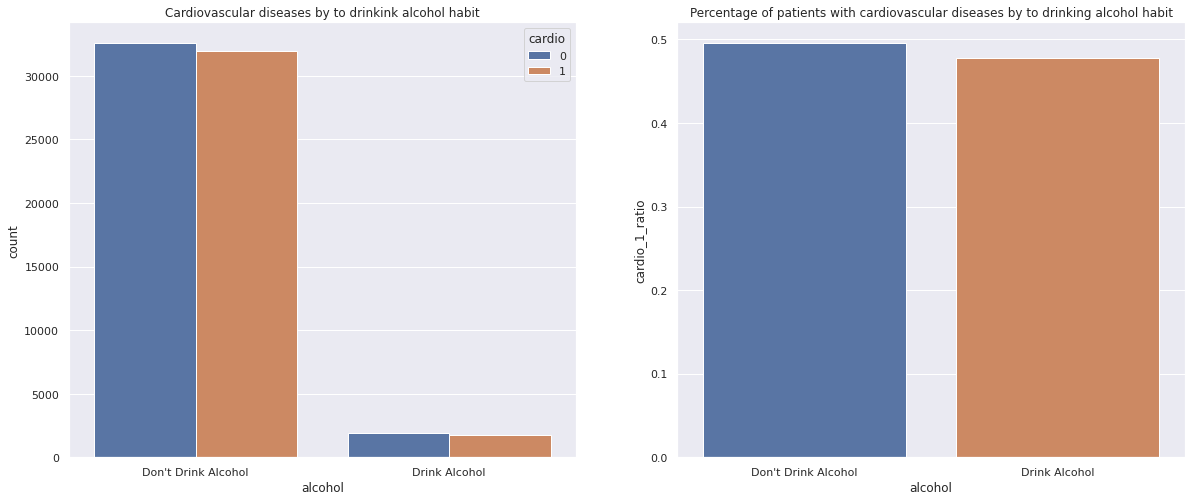

In [36]:
# Graph size
plt.figure(figsize=(20,8))

# Count of patients with cardiovascular diseases by to drinking alcohol habit
plt.subplot(1, 2, 1)
sns.countplot(x='alco', data=df3, hue=df3['cardio']).set_title("Cardiovascular diseases by to drinkink alcohol habit");
plt.xlabel('alcohol');
plt.xticks(ticks=[0, 1], labels=["Don't Drink Alcohol", 'Drink Alcohol']);

# Percentage of patients with cardiovascular diseases by to drinking alcohol habit
aux1 = (df3[['alco', 'cardio']].groupby('alco').sum().reset_index()).rename(columns={'alco': 'alcohol', 'cardio': 'cardio_1'})
aux1['cardio_total'] = df3[['alco', 'cardio']].groupby('alco').count().reset_index()['cardio']
aux1['cardio_0'] = aux1['cardio_total'] - aux1['cardio_1']
aux1['cardio_1_ratio'] = aux1['cardio_1'] / aux1['cardio_total']
aux1 = aux1[['alcohol', 'cardio_1', 'cardio_0', 'cardio_total', 'cardio_1_ratio']]

plt.subplot(1, 2, 2)
sns.barplot(data=aux1, x='alcohol', y='cardio_1_ratio').set_title('Percentage of patients with cardiovascular diseases by to drinking alcohol habit')
plt.xticks(ticks=[0, 1], labels=["Don't Drink Alcohol", 'Drink Alcohol']);

- There are more cases of cardiovascular disease in patients that **don't** drink alcohol.

**H2. There are more cases of cardiovascular disease in patients that doesn't practice physical activity.**

**TRUE**

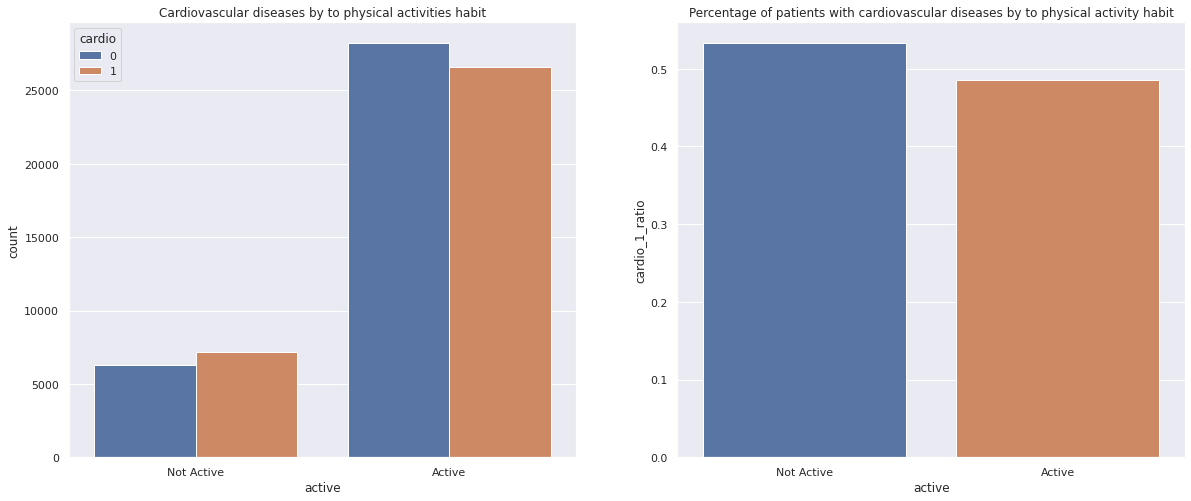

In [37]:
# Graph size
plt.figure(figsize=(20,8))

# Count of patients with cardiovascular diseases by to physical activities habit
plt.subplot(1, 2, 1)
sns.countplot(x='active', hue='cardio', data=df3).set_title('Cardiovascular diseases by to physical activities habit');
plt.xticks(ticks=[0, 1], labels=["Not Active", 'Active']);

# Percentage of patients with cardiovascular diseases by to physical activities habit
aux2 = (df3[['active', 'cardio']].groupby('active').sum().reset_index()).rename(columns={'cardio': 'cardio_1'})
aux2['cardio_total'] = df3[['active', 'cardio']].groupby('active').count().reset_index()['cardio']
aux2['cardio_1_ratio'] = aux2['cardio_1'] / aux2['cardio_total']

plt.subplot(1, 2, 2);
sns.barplot(x='active', y='cardio_1_ratio', data=aux2).set_title('Percentage of patients with cardiovascular diseases by to physical activity habit');
plt.xticks(ticks=[0, 1], labels=['Not Active', 'Active']);

In [38]:
aux2

,active,cardio_1,cardio_total,cardio_1_ratio
0,0,7146,13407,0.533005
1,1,26591,54813,0.485122


- There are more cases of cardiovascular disease in patients that don't do physical activity.

**H3. There are more cases of cardiovascular disease in patients that smokes.** 

**FALSE**

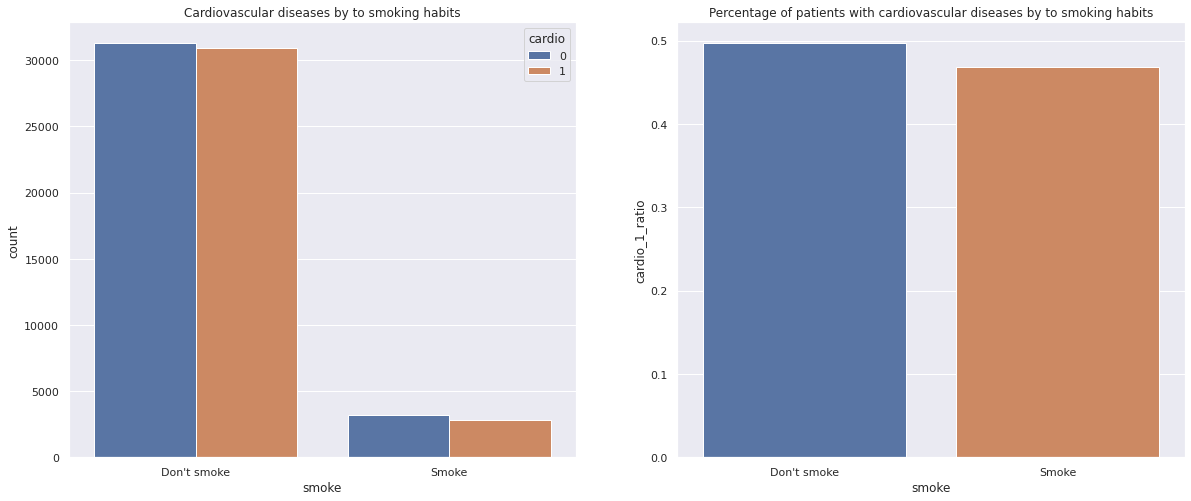

In [39]:
# Graph size
plt.figure(figsize=(20,8))

# Count of patients with cardiovascular diseases by to smoking habit
plt.subplot(1, 2, 1)
sns.countplot(x='smoke', hue='cardio', data=df3).set_title('Cardiovascular diseases by to smoking habits');
plt.xticks(ticks=[0, 1], labels=["Don't smoke", 'Smoke']);

# Percentage of patients with cardiovascular diseases by to smoking habit
aux3 = (df3[['smoke', 'cardio']].groupby('smoke').sum().reset_index()).rename(columns={'cardio': 'cardio_1'})
aux3['cardio_total'] = df3[['smoke', 'cardio']].groupby('smoke').count().reset_index()['cardio']
aux3['cardio_1_ratio'] = aux3['cardio_1'] / aux3['cardio_total']

plt.subplot(1, 2, 2)
sns.barplot(x='smoke', y='cardio_1_ratio', data=aux3).set_title('Percentage of patients with cardiovascular diseases by to smoking habits');
plt.xticks(ticks=[0, 1], labels=["Don't smoke", 'Smoke']);

In [40]:
aux3

,smoke,cardio_1,cardio_total,cardio_1_ratio
0,0,30922,62216,0.497010
1,1,2815,6004,0.468854


- There are more cases of cardiovascular disease in patients that **don't** smoke.

**H4. There are more cases of cardiovascular disease in patients that has well above normal cholesterol level** 

**TRUE**

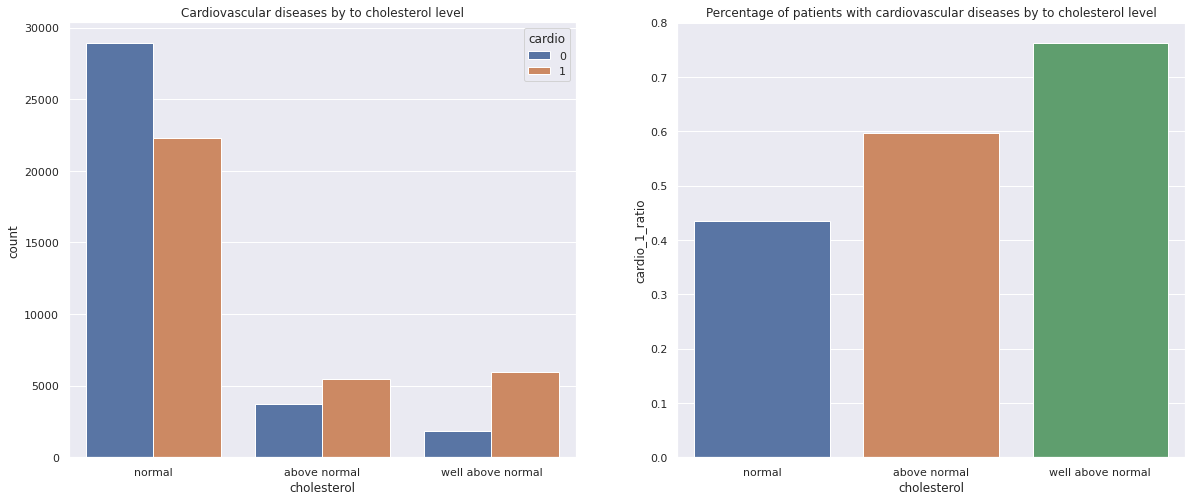

In [41]:
# Graph size
plt.figure(figsize=(20, 8))

# Count of patients with cardiovascular diseases by to cholesterol level
plt.subplot(1, 2, 1)
sns.countplot(x='cholesterol', hue='cardio', data=df3).set_title('Cardiovascular diseases by to cholesterol level');
plt.xticks(ticks=[0, 1, 2], labels=['normal', 'above normal', 'well above normal']);

# Percentage of patients with cardiovascular diseases by to cholesterol level
aux4 = (df3[['cholesterol', 'cardio']].groupby('cholesterol').sum().reset_index()).rename(columns={'cardio': 'cardio_1'})
aux4['cardio_total'] = df3[['cholesterol', 'cardio']].groupby('cholesterol').count().reset_index()['cardio']
aux4['cardio_1_ratio'] = aux4['cardio_1'] / aux4['cardio_total']

plt.subplot(1, 2, 2)
sns.barplot(x='cholesterol', y='cardio_1_ratio', data=aux4).set_title('Percentage of patients with cardiovascular diseases by to cholesterol level');
plt.xticks(ticks=[0, 1, 2], labels=['normal', 'above normal', 'well above normal']);

In [42]:
aux4

,cholesterol,cardio_1,cardio_total,cardio_1_ratio
0,1,22293,51204,0.435376
1,2,5492,9209,0.596373
2,3,5952,7807,0.762393


- There are more cases of cardiovascular disease the higher the cholesterol level.

**H5. There are more cases of cardiovascular disease in patients that has well above normal glucose level.**

**TRUE**

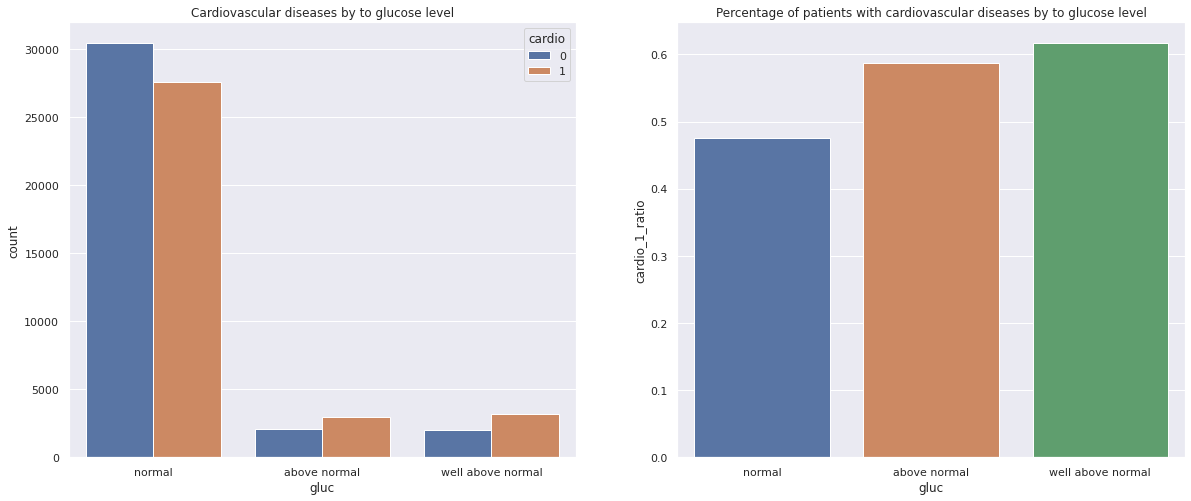

In [43]:
# Graph size
plt.figure(figsize=(20, 8))

# Count of patients with cardiovascular diseases by to glucose level
plt.subplot(1, 2, 1)
sns.countplot(x='gluc', hue='cardio', data=df3).set_title('Cardiovascular diseases by to glucose level');
plt.xticks(ticks=[0, 1, 2], labels=['normal', 'above normal', 'well above normal']);

# Percentage of patients with cardiovascular diseases by to glucose level
aux5 = (df3[['gluc', 'cardio']].groupby('gluc').sum().reset_index()).rename(columns={'cardio': 'cardio_1'})
aux5['cardio_total'] = df3[['gluc', 'cardio']].groupby('gluc').count().reset_index()['cardio']
aux5['cardio_1_ratio'] = aux5['cardio_1'] / aux5['cardio_total']

plt.subplot(1, 2, 2)
sns.barplot(x='gluc', y='cardio_1_ratio', data=aux5).set_title('Percentage of patients with cardiovascular diseases by to glucose level');
plt.xticks(ticks=[0, 1, 2], labels=['normal', 'above normal', 'well above normal']);

In [44]:
aux5

,gluc,cardio_1,cardio_total,cardio_1_ratio
0,1,27607,58042,0.475638
1,2,2940,5006,0.587295
2,3,3190,5172,0.616783


- There are more cases of cardiovascular disease the higher the glucose level.

**H6. There are more cases of cardiovascular disease in patients that has higher systolic blood pressure.**

**TRUE**

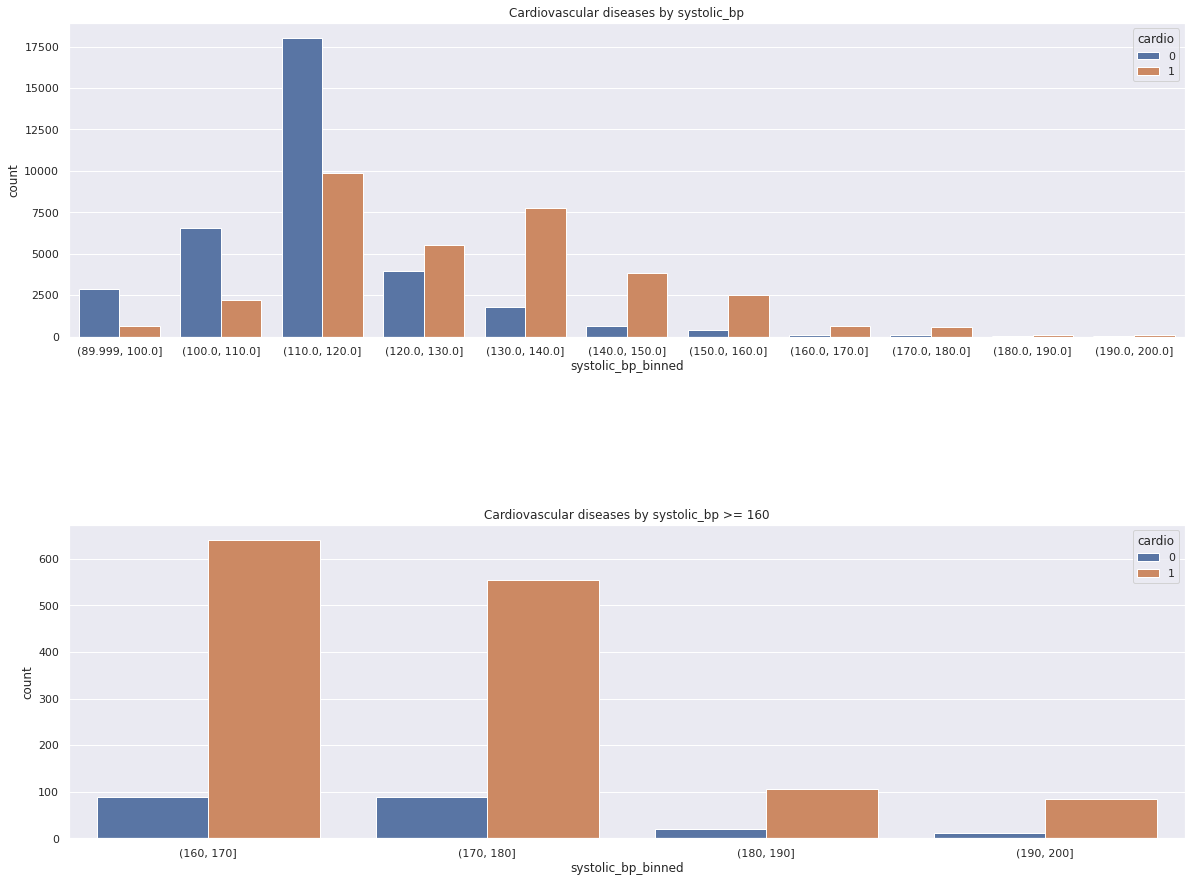

In [45]:
# Graph size
plt.figure(figsize=(20, 15));
plt.subplots_adjust(hspace=0.6);

# Set bins for systolic_bp
bins_systolic_bp = list(np.arange(90, 201, 10))
aux6 = df3[['systolic_bp', 'cardio']]
aux6['systolic_bp_binned'] = pd.cut(x=aux6['systolic_bp'], bins=bins_systolic_bp, include_lowest=True)

# Count of patients with cardiovascular diseases by systolic_bp
plt.subplot(2, 1, 1)
sns.countplot(x='systolic_bp_binned', hue='cardio', data=aux6).set_title('Cardiovascular diseases by systolic_bp');

# Systolic_bp >= 161
bins_high_bp = list(np.arange(160, 201, 10))
aux6_1 = df3[['systolic_bp', 'cardio']]
aux6_1['systolic_bp_binned'] = pd.cut(x=aux6_1['systolic_bp'], bins=bins_high_bp)


plt.subplot(2, 1, 2)
sns.countplot(x='systolic_bp_binned', hue='cardio', data=aux6_1).set_title('Cardiovascular diseases by systolic_bp >= 160');

- There are more cases of cardiovascular disease the higher systolic blood pressure.

**H7. There are more cases of cardiovascular disease in patients that has higher diastolic blood pressure.**

**TRUE**

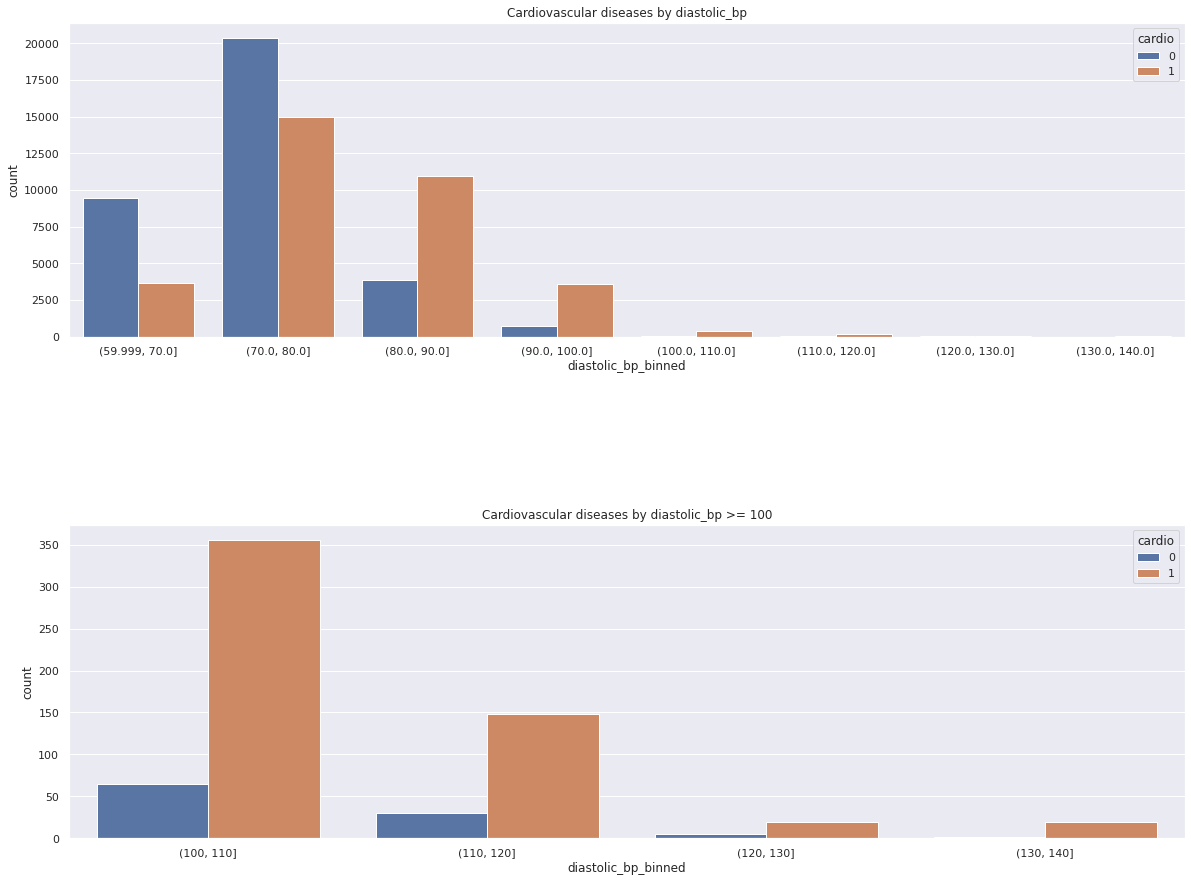

In [46]:
# Graph size
plt.figure(figsize=(20, 15));
plt.subplots_adjust(hspace=0.6)

# Set bins for diastolic_bp
bins_diastolic_bp = list(np.arange(60, 141, 10))
aux7 = df3[['diastolic_bp', 'cardio']]
aux7['diastolic_bp_binned'] = pd.cut(x=aux7['diastolic_bp'], bins=bins_diastolic_bp, include_lowest=True)

# Count of patients with cardiovascular diseases by diastolic_bp
plt.subplot(2, 1, 1)
sns.countplot(x='diastolic_bp_binned', hue='cardio', data=aux7).set_title('Cardiovascular diseases by diastolic_bp');

# Diastolic_bp >= 100
bins_high_bp = list(np.arange(100, 141, 10))
aux7_1 = df3[['diastolic_bp', 'cardio']]
aux7_1['diastolic_bp_binned'] = pd.cut(x=aux7_1['diastolic_bp'], bins=bins_high_bp)

plt.subplot(2, 1, 2)
sns.countplot(x='diastolic_bp_binned', hue='cardio', data=aux7_1).set_title('Cardiovascular diseases by diastolic_bp >= 100');

- There are more cases of cardiovascular disease the higher diastolic blood pressure.

**H8. There are more cases of cardiovascular disease in patients that are taller.**

**TRUE** But also, there are more cardiovascular diseases in very short patients (shorter than 155 cm).

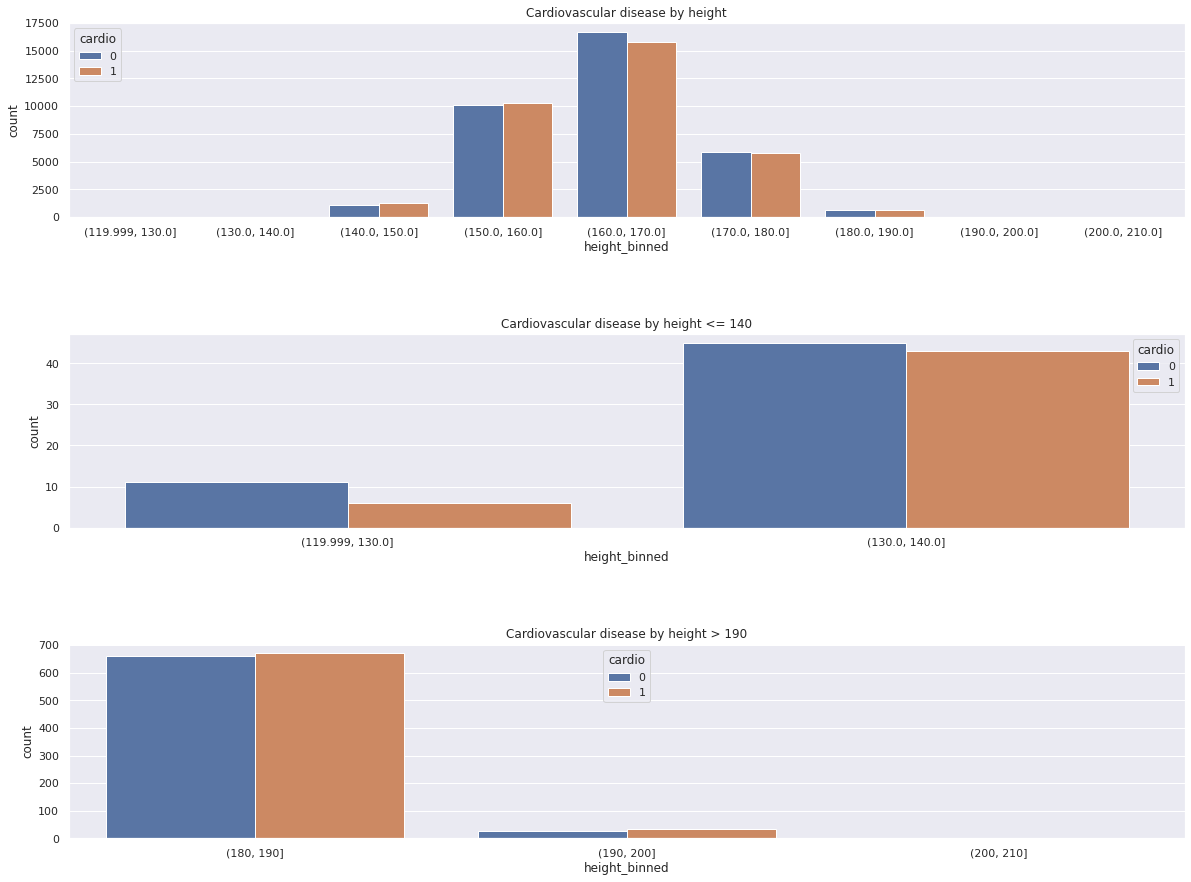

In [47]:
# Graph size
plt.figure(figsize=(20, 15));
plt.subplots_adjust(hspace=0.6)

# Set bins for height
bins_height = list(np.arange(120, 211, 10))
aux8 = df3[['height', 'cardio']]
aux8['height_binned'] = pd.cut(x=aux8['height'], bins=bins_height, include_lowest=True)

plt.subplot(3, 1, 1)
sns.countplot(x='height_binned', hue='cardio', data=aux8, ).set_title('Cardiovascular disease by height');

# Height <= 140 and > 190 
bins_zoom = list(np.arange(120, 141, 10))
aux8_1 = df3[['height', 'cardio']]
aux8_1['height_binned'] = pd.cut(x=aux8_1['height'], bins=bins_zoom, include_lowest=True)

plt.subplot(3, 1, 2)
sns.countplot(x='height_binned', hue='cardio', data=aux8_1).set_title('Cardiovascular disease by height <= 140');

# Height > 180 
bins_zoom = list(np.arange(180, 211, 10))
aux8_2 = df3[['height', 'cardio']]
aux8_2['height_binned'] = pd.cut(x=aux8_1['height'], bins=bins_zoom)

plt.subplot(3, 1, 3)
sns.countplot(x='height_binned', hue='cardio', data=aux8_2).set_title('Cardiovascular disease by height > 190');


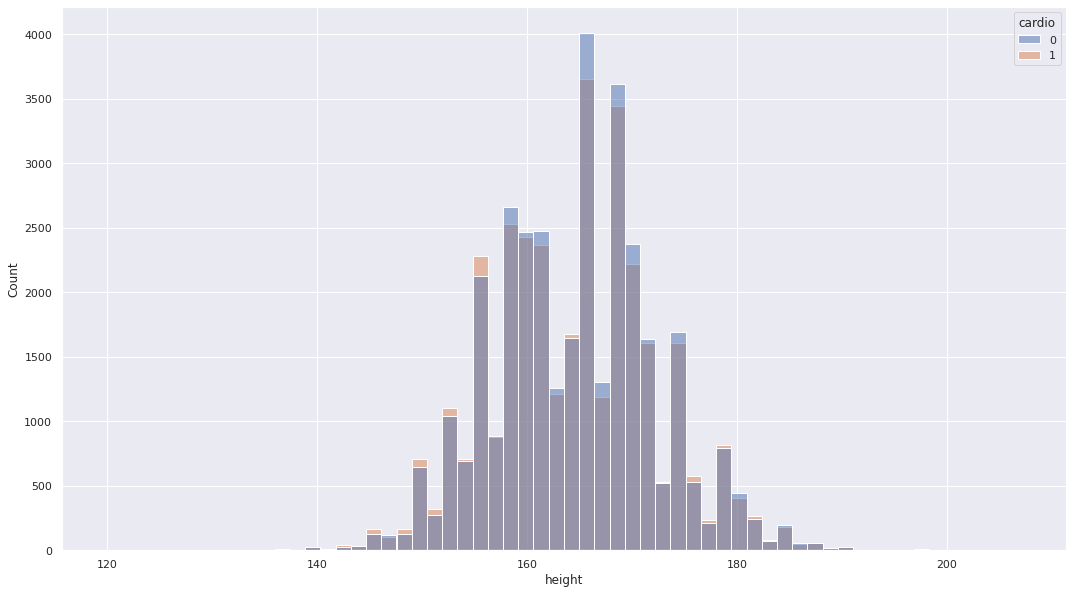

In [48]:
plt.figure(figsize=(18,10))
sns.histplot(x='height', hue='cardio', data=aux8, bins=60);

- There are more cases of cardiovascular disease when height is greater than 175 cm. And also, there are more cases when height is less than 155 cm. 

**H9. There are more cases of cardiovascular disease in patients that are older.** 

**TRUE**

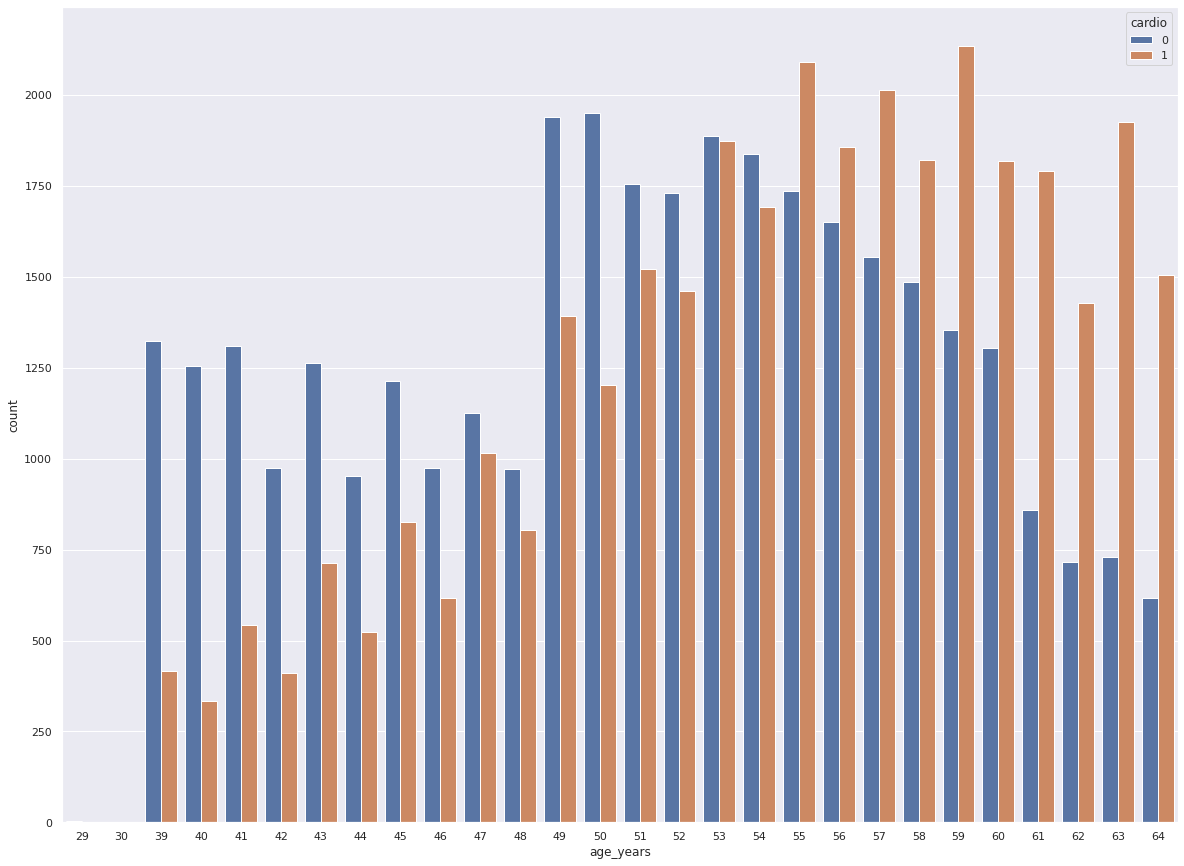

In [49]:
plt.figure(figsize=(20, 15));
sns.countplot(x='age_years', hue='cardio', data=df3);

- There are more cases of cardiovascular diseases in patients older than 55 years old.

**H10. There are more cases of cardiovascular disease in patients that weights more.**

**TRUE**

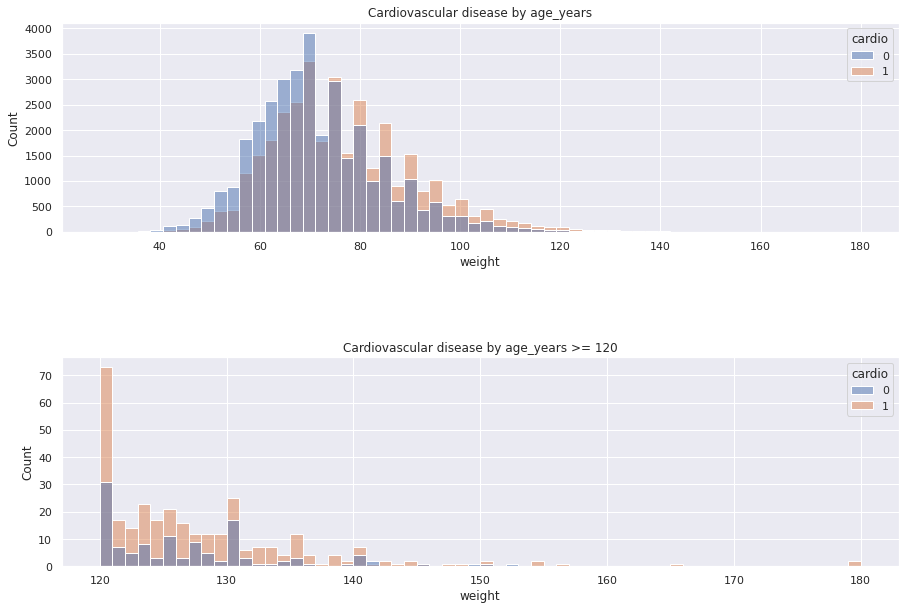

In [50]:
# Set Graphic
plt.figure(figsize=(15,10))
plt.subplots_adjust(hspace=0.6);

# Count of patients with cardiovascular diseases by weight
plt.subplot(2, 1, 1)
sns.histplot(x='weight', hue='cardio', data=df3, bins=60).set_title('Cardiovascular disease by age_years');

# weight > 120
selection = df3[df3['weight'] >= 120]

plt.subplot(2, 1, 2)
sns.histplot(x='weight', hue='cardio', data=selection, bins=60).set_title('Cardiovascular disease by age_years >= 120');

- There are more cases of cardiovascular diseases in patients that weight more than 75 kg.

**H11. There are more cases of cardiovascular disease in patients that are male.**

**TRUE**

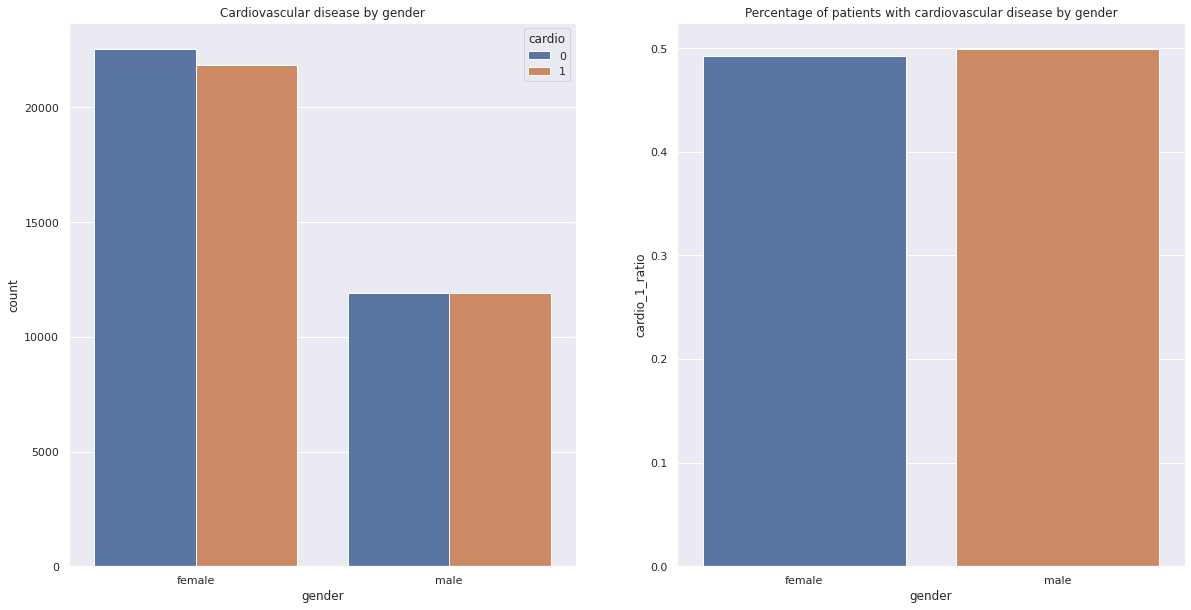

In [51]:
# Set Graphic
plt.figure(figsize=(20,10));

# Count of patients with cardiovascular diseases by gender
plt.subplot(1, 2, 1)
sns.countplot(x='gender', hue='cardio', data=df3).set_title('Cardiovascular disease by gender');
plt.xticks(ticks=[0, 1], labels=['female', 'male']);

# Percentage of patients with cardiovascular diseases by gender
aux10 = (df3[['gender', 'cardio']].groupby('gender').sum().reset_index()).rename(columns={'cardio': 'cardio_1'})
aux10['cardio_total'] = df3[['gender', 'cardio']].groupby('gender').count().reset_index()['cardio']
aux10['cardio_1_ratio'] = aux10['cardio_1'] / aux10['cardio_total']

plt.subplot(1, 2, 2);
sns.barplot(x='gender', y='cardio_1_ratio', data=aux10).set_title('Percentage of patients with cardiovascular disease by gender');
plt.xticks(ticks=[0, 1], labels=['female', 'male']);

In [52]:
aux10

,gender,cardio_1,cardio_total,cardio_1_ratio
0,1,21837,44394,0.491891
1,2,11900,23826,0.499454


- There are more cases of cardiovascular diseases in male (49.94%) patients than female (49.18%), but the diference is negligible.

### 3.3.1. Hypothesis Summary

**1.** There are more cases of cardiovascular disease in patients that drinks alcohol; (FALSE)

**2.** There are more cases of cardiovascular disease in patients that doesn't practice physical activity; (TRUE)

**3.** There are more cases of cardiovascular disease in patients that smokes; (FALSE)

**4.** There are more cases of cardiovascular disease in patients that has well above normal cholesterol level; (TRUE)

**5.** There are more cases of cardiovascular disease in patients that has well above normal glucose level; (TRUE)

**6.** There are more cases of cardiovascular disease in patients that has higher systolic blood pressure; (TRUE)

**7.** There are more cases of cardiovascular disease in patients that has higher diastolic blood pressure; (TRUE)

**8.** There are more cases of cardiovascular disease in patients that are taller; (TRUE)

**9.** There are more cases of cardiovascular disease in patients that are older; (TRUE)

**10.** There are more cases of cardiovascular disease in patients that weights more; (TRUE)

**11.** There are more cases of cardiovascular disease in patients that are male. (TRUE)

In [53]:
tab = [['H1', 'FALSE'],
       ['H2', 'TRUE'],
       ['H3', 'FALSE'],
       ['H4', 'TRUE'],
       ['H5', 'TRUE'],
       ['H6', 'TRUE'],
       ['H7', 'TRUE'],
       ['H8', 'TRUE'],
       ['H9', 'TRUE'],
       ['H10', 'TRUE'],
       ['H11', 'TRUE']]




H_summary = pd.DataFrame(data=tab, columns=['Hypothesis', 'Conclusion'])
H_summary

,Hypothesis,Conclusion
0,H1,FALSE
1,H2,TRUE
2,H3,FALSE
3,H4,TRUE
4,H5,TRUE
5,H6,TRUE
6,H7,TRUE
7,H8,TRUE
8,H9,TRUE
9,H10,TRUE


## 3.4. Multivariate Analysis

### 3.4.1. Numerical Attributes

In [54]:
aux1.head()

,alcohol,cardio_1,cardio_0,cardio_total,cardio_1_ratio
0,0,31994,32581,64575,0.495455
1,1,1743,1902,3645,0.478189


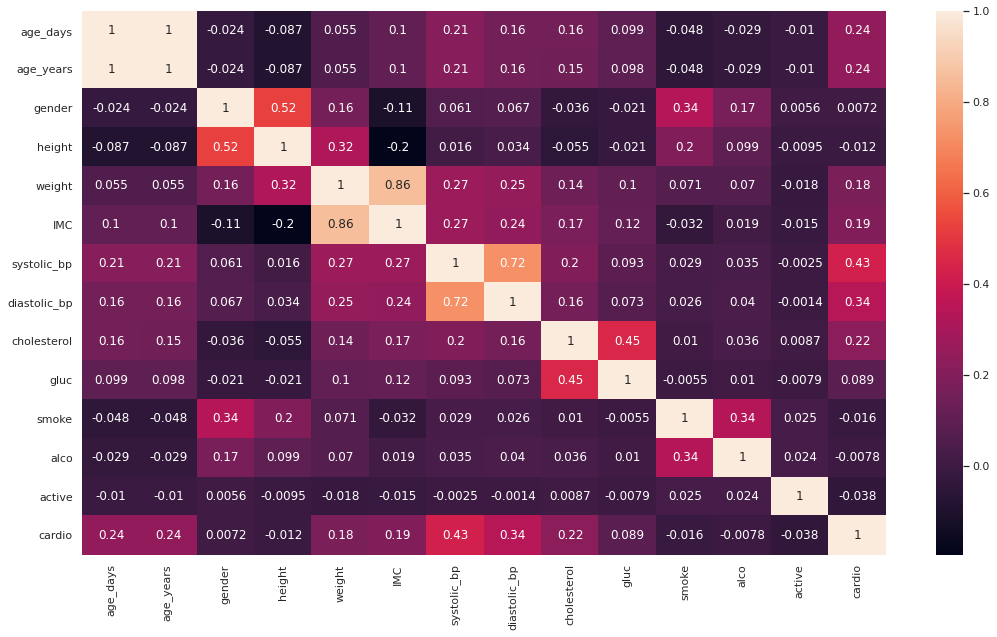

In [55]:
# Graph size
plt.figure(figsize=(18,10));

# Drop columns = id, IMC_class, bp_class.
aux1 = df3.drop(['id', 'IMC_class', 'bp_class'], axis=1)

# Correlation by Pearson method
correlation = aux1.corr(method='pearson')
sns.heatmap(correlation, annot=True);

**Highlights:**
- **IMC and weight** have strong correlation (0.86);
- **Systolic_bp and diastolic_bp** have strong correlation (0.72);
- **Gender and height** have moderate correlation (0.52);
- **Glucose and cholesterol** have moderate correlation (0.45).
- **Cardio and systolic_bp** have moderate correlation (0.43);

# 4.0. DATA PREPARATION

In [56]:
df4 = df3.copy()
df4.head()

,id,age_days,age_years,gender,height,weight,IMC,IMC_class,systolic_bp,diastolic_bp,bp_class,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,50,2,168,62.0,21.967120,health,110,80,hypertension 1,1,1,0,0,1,0
1,1,20228,55,1,156,85.0,34.927679,obese,140,90,hypertension 2,3,1,0,0,1,1
2,2,18857,51,1,165,64.0,23.507805,health,130,70,hypertension 1,3,1,0,0,0,1
3,3,17623,48,2,169,82.0,28.710479,overweight,150,100,hypertension 2,1,1,0,0,1,1
4,4,17474,47,1,156,56.0,23.011177,health,100,60,normal,1,1,0,0,0,0


## 4.1. Split Dataframe Into Training and Test Dataset

In [57]:
# Drop unuseful columns (id, age_years, IMC_class, bp_class)
df4.drop(columns=['id', 'age_years', 'IMC_class', 'bp_class'], inplace=True)

In [58]:
df4.head()

,age_days,gender,height,weight,IMC,systolic_bp,diastolic_bp,cholesterol,gluc,smoke,alco,active,cardio
0,18393,2,168,62.0,21.967120,110,80,1,1,0,0,1,0
1,20228,1,156,85.0,34.927679,140,90,3,1,0,0,1,1
2,18857,1,165,64.0,23.507805,130,70,3,1,0,0,0,1
3,17623,2,169,82.0,28.710479,150,100,1,1,0,0,1,1
4,17474,1,156,56.0,23.011177,100,60,1,1,0,0,0,0


In [59]:
# Spliting Dataframe
X_train, X_test = train_test_split(df4, test_size=0.20, random_state=42)

In [60]:
# Training Dataset
# Separating target Variable from X_train
y_train = X_train['cardio'].copy()

# Drop target variable from X_train
X_train.drop(columns='cardio', inplace=True);

In [61]:
# Test Dataset
# Separating target Variable from X_train
y_test = X_test['cardio'].copy()

# Drop target variable from X_test
X_test.drop(columns='cardio', inplace=True);

In [62]:
# Checking X_train
X_train.head()

,age_days,gender,height,weight,IMC,systolic_bp,diastolic_bp,cholesterol,gluc,smoke,alco,active
9805,22486,2,157,60.0,24.341758,110,80,1,1,0,0,1
35122,18268,1,160,74.0,28.906250,100,70,1,1,0,0,1
60196,18265,1,157,76.0,30.832894,160,100,1,1,0,0,1
62847,21633,2,169,70.0,24.508946,125,80,1,1,0,0,1
69188,17472,1,157,55.4,22.475557,100,70,1,1,0,0,1


In [63]:
print(f'The X_train dataset has: {X_train.shape[0]} rows.\nThe X_train dataset has: {X_train.shape[1]} columns')

The X_train dataset has: 54576 rows.
The X_train dataset has: 12 columns


In [64]:
# Checking X_test
X_test.head()

,age_days,gender,height,weight,IMC,systolic_bp,diastolic_bp,cholesterol,gluc,smoke,alco,active
2042,19224,1,165,63.0,23.140496,120,80,1,1,0,0,1
20496,22018,1,146,83.0,38.937887,140,90,3,3,0,0,1
60090,21273,1,165,65.0,23.875115,110,70,1,1,0,0,1
38107,16224,2,172,80.0,27.041644,120,80,1,1,0,0,0
32238,14718,1,160,65.0,25.390625,120,80,1,1,0,0,1


In [65]:
print(f'The X_test dataset has: {X_test.shape[0]} rows.\nThe X_test dataset has: {X_test.shape[1]} columns')

The X_test dataset has: 13644 rows.
The X_test dataset has: 12 columns


## 4.2. Rescaling

We are going to use two rescaling methods for numerical features: **MinMaxScaler** and **Robust Scaler**.

We will utilize **MinMaxScaler** when the feature does not present huge outliers.

And the **Robust Scaler** is going to be used in features that does present huge outliers.

So now, we are going to check which rescaling method to use for each feature.

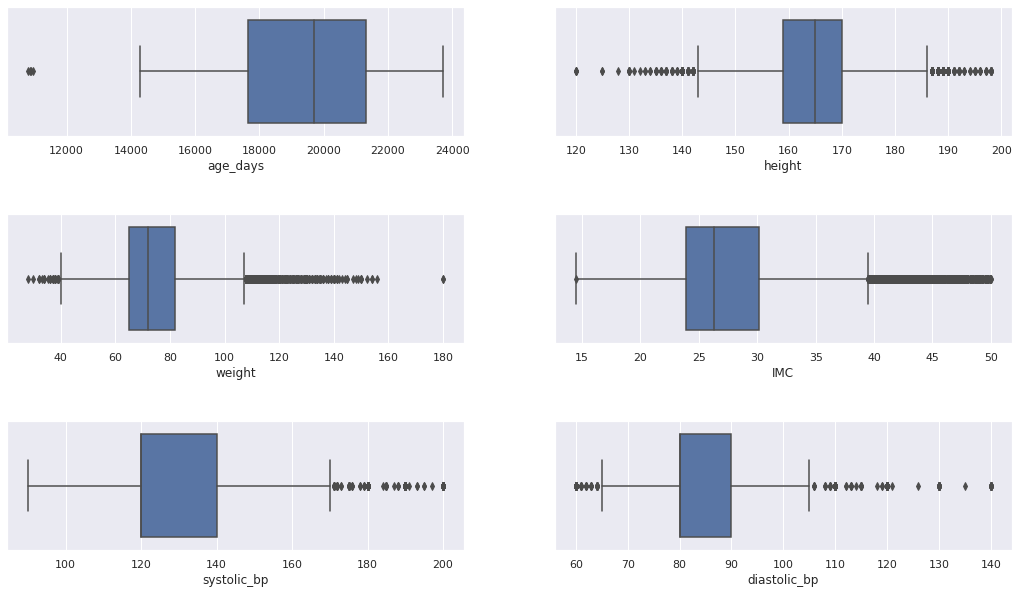

In [66]:
# Numerical Variables (age_days, height, weight, IMC, systolic_bp, diastolic_bp)
# boxplot to see range of outliers

# Setting graph config
plt.figure(figsize=(18, 10));
plt.subplots_adjust(hspace=0.6);

# age_days ( MinMaxScaler)
plt.subplot(3, 2, 1);
sns.boxplot(X_train['age_days']);

# height (Robust Scaler)
plt.subplot(3, 2, 2);
sns.boxplot(X_train['height']);

# weight (Robust Scaler)
plt.subplot(3, 2, 3);
sns.boxplot(X_train['weight']);

# IMC (MinMaxScaler)
plt.subplot(3, 2, 4);
sns.boxplot(X_train['IMC']);

# systolic_bp (MinMaxScaler)
plt.subplot(3, 2, 5);
sns.boxplot(X_train['systolic_bp']);

# diastolic_bp (MinMaxScaler)
plt.subplot(3, 2, 6);
sns.boxplot(X_train['diastolic_bp']);

In [67]:
# Instantiating scalers
mms = MinMaxScaler()
rs = RobustScaler()

In [68]:
# MinMaxScaler (age_days, IMC, systolic_bp, diastolic_bp)
# age
X_train['age_days'] = mms.fit_transform(X_train[['age_days']].values)
X_test['age_days'] = mms.fit_transform(X_test[['age_days']].values)

# IMC
X_train['IMC'] = mms.fit_transform(X_train[['IMC']].values)
X_test['IMC'] = mms.fit_transform(X_test[['IMC']].values)

# systolic_bp
X_train['systolic_bp'] = mms.fit_transform(X_train[['systolic_bp']].values)
X_test['systolic_bp'] = mms.fit_transform(X_test[['systolic_bp']].values)

# diastolic_bp
X_train['diastolic_bp'] = mms.fit_transform(X_train[['diastolic_bp']].values)
X_test['diastolic_bp'] = mms.fit_transform(X_test[['diastolic_bp']].values)

In [69]:
# Robust Scaler (height, weight)
# height
X_train['height'] = rs.fit_transform(X_train[['height']].values)
X_test['height'] = rs.fit_transform(X_test[['height']].values)

# weight
X_train['weight'] = rs.fit_transform(X_train[['weight']].values)
X_test['weight'] = rs.fit_transform(X_test[['weight']].values)

In [70]:
X_train.head(10)

,age_days,gender,height,weight,IMC,systolic_bp,diastolic_bp,cholesterol,gluc,smoke,alco,active
9805,0.904994,2,-0.727273,-0.705882,0.277650,0.181818,0.250,1,1,0,0,1
35122,0.578397,1,-0.454545,0.117647,0.406153,0.090909,0.125,1,1,0,0,1
60196,0.578165,1,-0.727273,0.235294,0.460393,0.636364,0.500,1,1,0,0,1
62847,0.838947,2,0.363636,-0.117647,0.282357,0.318182,0.250,1,1,0,0,1
69188,0.516763,1,-0.727273,-0.976471,0.225111,0.090909,0.125,1,1,0,0,1
58259,0.639721,1,-1.090909,-0.529412,0.350030,0.181818,0.000,2,2,0,0,1
12903,0.981804,1,-0.818182,0.000000,0.425284,0.363636,0.250,1,1,0,0,1
63232,0.355323,2,0.454545,-0.411765,0.225556,0.181818,0.250,1,1,0,0,0
53906,0.594967,2,0.272727,0.235294,0.350444,0.272727,0.250,1,1,0,0,1
4131,0.568254,2,0.909091,0.235294,0.291010,0.272727,0.250,3,3,1,0,1


In [71]:
X_test.head()

,age_days,gender,height,weight,IMC,systolic_bp,diastolic_bp,cholesterol,gluc,smoke,alco,active
2042,0.525962,1,0.000000,-0.529412,0.243190,0.272727,0.250,1,1,0,0,1
20496,0.823862,1,-1.727273,0.647059,0.689069,0.454545,0.375,3,3,0,0,1
60090,0.744429,1,0.000000,-0.411765,0.263925,0.181818,0.125,1,1,0,0,1
38107,0.206099,2,0.636364,0.470588,0.353300,0.272727,0.250,1,1,0,0,0
32238,0.045527,1,-0.454545,-0.411765,0.306700,0.272727,0.250,1,1,0,0,1


# 5.0. FEATURE SELECTION

## 5.1. Random Forest as Feature Selector

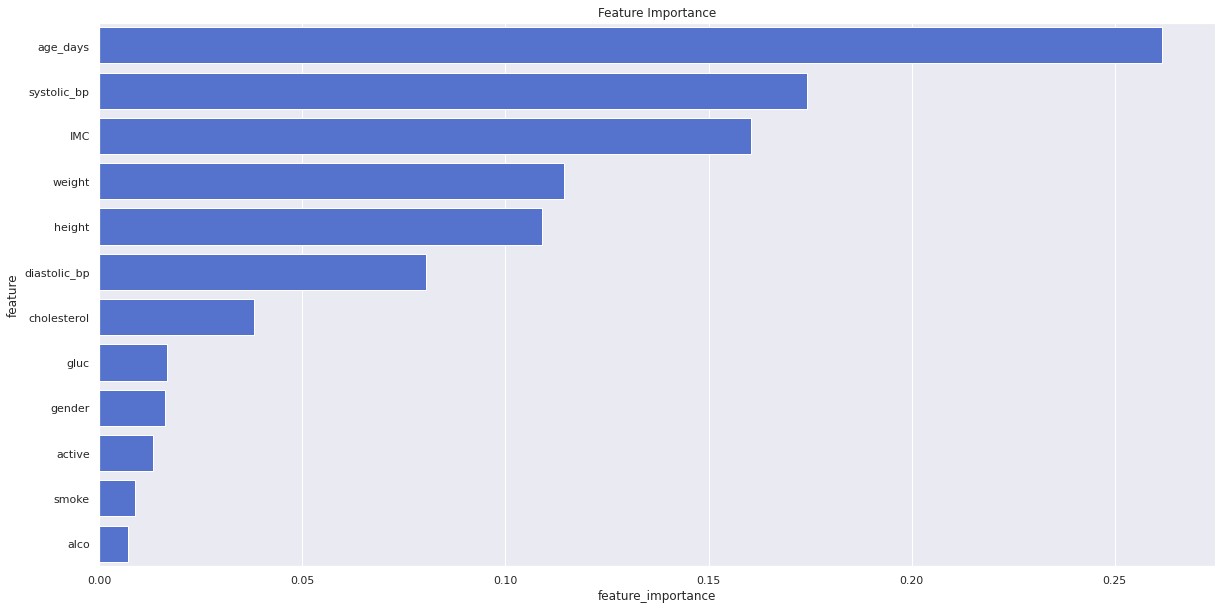

In [72]:
# Instantiates Random Forest Classifier
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# feature importance dataframe
feature_imp = pd.DataFrame({'feature': X_train.columns,
                            'feature_importance': rf.feature_importances_}) \
                            .sort_values('feature_importance', ascending=False) \
                            .reset_index(drop=True)

# plot feature importance
plt.figure(figsize=(20,10));
sns.barplot(x='feature_importance', y='feature', data=feature_imp, orient='h', color='royalblue').set_title('Feature Importance');

In [73]:
# Selecting most relevant features
cols_selected = feature_imp[:8]
cols_selected

,feature,feature_importance
0,age_days,0.261688
1,systolic_bp,0.174176
2,IMC,0.160478
3,weight,0.114433
4,height,0.109092
5,diastolic_bp,0.080360
6,cholesterol,0.038107
7,gluc,0.016693


In [74]:
cols_list = cols_selected['feature'].to_list()
cols_list

['age_days',
 'systolic_bp',
 'IMC',
 'weight',
 'height',
 'diastolic_bp',
 'cholesterol',
 'gluc']

## 5.2. Test other models as feature selector (CRISP 2)

# 6.0. MACHINE LEARNING MODELLING

In [75]:
x_train = X_train[cols_list]
x_test = X_test[cols_list]

## 6.1. Baseline Model

The baseline for comparison is the actual precision reached by the specialist, which is between 55% and 65%.

## 6.2. Logistic Regression Classifier

In [76]:
# Train Logistic Regression Model
logreg = LogisticRegression(random_state=42)
logreg.fit(x_train, y_train)

# Predict
logreg_yhat = logreg.predict(x_test)

# ROC-AUC
logreg_cv = cross_val_predict(logreg, x_train, y_train, cv=5, method='decision_function')
logreg_roc_auc = roc_auc_score(y_train, logreg_cv)

# performance
logreg_performance = pd.DataFrame(['Logistic Regression',
                                    accuracy_score(y_test, logreg_yhat),
                                    precision_score(y_test, logreg_yhat),
                                    recall_score(y_test, logreg_yhat),
                                    f1_score(y_test, logreg_yhat),
                                    logreg_roc_auc]).T
logreg_performance.columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']

logreg_performance

,Model,Accuracy,Precision,Recall,F1-Score,ROC-AUC
0,Logistic Regression,0.711302,0.760376,0.603248,0.672759,0.792046


## 6.3. Stochastic Gradient Descent Classifier (SGDClassifier)

In [77]:
# Train SGDClassifier
sgdc = SGDClassifier(random_state=42)
sgdc.fit(x_train, y_train)

# Predict
sgdc_yhat = sgdc.predict(x_test)

# ROC-AUC
sgdc_cv = cross_val_predict(sgdc, x_train, y_train, cv=5, method='decision_function')
sgd_roc_auc = roc_auc_score(y_train, sgdc_cv)

# performance
sgdc_performance = pd.DataFrame(['SGDClassifier',
                                    accuracy_score(y_test, sgdc_yhat),
                                    precision_score(y_test, sgdc_yhat),
                                    recall_score(y_test, sgdc_yhat),
                                    f1_score(y_test, sgdc_yhat),
                                    sgd_roc_auc]).T
sgdc_performance.columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']

sgdc_performance

,Model,Accuracy,Precision,Recall,F1-Score,ROC-AUC
0,SGDClassifier,0.715553,0.740363,0.649583,0.692009,0.787443


## 6.4. Random Forest Classifier

In [78]:
# Train Random Forest
randforest = RandomForestClassifier(random_state=42)
randforest.fit(x_train, y_train)

# Predict
randforest_yhat = randforest.predict(x_test)

# ROC-AUC
randforest_cv = cross_val_predict(randforest, x_train, y_train, cv=5)
randforest_roc_auc = roc_auc_score(y_train, randforest_cv)

# performance
randforest_performance = pd.DataFrame(['Random Forest Classifier',
                                    accuracy_score(y_test, randforest_yhat),
                                    precision_score(y_test, randforest_yhat),
                                    recall_score(y_test, randforest_yhat),
                                    f1_score(y_test, randforest_yhat),
                                    randforest_roc_auc]).T
randforest_performance.columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']

randforest_performance

,Model,Accuracy,Precision,Recall,F1-Score,ROC-AUC
0,Random Forest Classifier,0.702213,0.713182,0.660161,0.685648,0.705707


## 6.5. XGB Classifier

In [79]:
# Train Random Forest
xgboost = xgb.XGBClassifier(random_state=42, eval_metric='error')
xgboost.fit(x_train, y_train);

# Predict
xgboost_yhat = xgboost.predict(x_test);

# ROC-AUC
xgboost_cv = cross_val_predict(xgboost, x_train, y_train, cv=5);
xgboost_roc_auc = roc_auc_score(y_train, xgboost_cv);

# performance
xgboost_performance = pd.DataFrame(['XGBooster Classifier',
                                    accuracy_score(y_test, xgboost_yhat),
                                    precision_score(y_test, xgboost_yhat),
                                    recall_score(y_test, xgboost_yhat),
                                    f1_score(y_test, xgboost_yhat),
                                    xgboost_roc_auc]).T
xgboost_performance.columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']

xgboost_performance

,Model,Accuracy,Precision,Recall,F1-Score,ROC-AUC
0,XGBooster Classifier,0.717605,0.741347,0.654201,0.695053,0.730137


## 6.6. Suport Vector Machine Classifier

In [80]:
# Training SVM
svm = SVC(random_state=42)
svm.fit(x_train, y_train)

# Predict
svm_yhat = svm.predict(x_test)

# ROC-AUC
svm_cv = cross_val_predict(svm, x_train, y_train, cv=5);
svm_roc_auc = roc_auc_score(y_train, svm_cv);

# performance
svm_performance = pd.DataFrame(['SVM Classifier',
                                    accuracy_score(y_test, svm_yhat),
                                    precision_score(y_test, svm_yhat),
                                    recall_score(y_test, svm_yhat),
                                    f1_score(y_test, svm_yhat),
                                    svm_roc_auc]).T
svm_performance.columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']

svm_performance

,Model,Accuracy,Precision,Recall,F1-Score,ROC-AUC
0,SVM Classifier,0.719877,0.755752,0.636174,0.690827,0.729315


## 6.7. K-Neareast Neighbors Classifier

In [81]:
# Training KNN
knn = KNeighborsClassifier()
knn.fit(x_train, y_train)
# Predict
knn_yhat = knn.predict(x_test)

# ROC-AUC
knn_cv = cross_val_predict(knn, x_train, y_train, cv=5);
knn_roc_auc = roc_auc_score(y_train, knn_cv);

# Performance
knn_performance = pd.DataFrame(['KNN',
                                    accuracy_score(y_test, knn_yhat),
                                    precision_score(y_test, knn_yhat),
                                    recall_score(y_test, knn_yhat),
                                    f1_score(y_test, knn_yhat),
                                    knn_roc_auc]).T
knn_performance.columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']

knn_performance

,Model,Accuracy,Precision,Recall,F1-Score,ROC-AUC
0,KNN,0.682718,0.695296,0.632002,0.66214,0.688315


## 6.8. LGBM Classifier

In [82]:
# Training LGBM
lgbm = LGBMClassifier(random_state=42)
lgbm.fit(x_train, y_train)

# Predict
lgbm_yhat = lgbm.predict(x_test)

# ROC-AUC
lgbm_cv = cross_val_predict(lgbm, x_train, y_train, cv=5);
lgbm_roc_auc = roc_auc_score(y_train, lgbm_cv);

# Performance
lgbm_performance = pd.DataFrame(['LGBM',
                                    accuracy_score(y_test, lgbm_yhat),
                                    precision_score(y_test, lgbm_yhat),
                                    recall_score(y_test, lgbm_yhat),
                                    f1_score(y_test, lgbm_yhat),
                                    lgbm_roc_auc]).T
lgbm_performance.columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']

lgbm_performance

,Model,Accuracy,Precision,Recall,F1-Score,ROC-AUC
0,LGBM,0.719584,0.744908,0.653903,0.696446,0.734755


## 6.9. Performance Comparison

In [83]:
performance_comparison = pd.concat([logreg_performance,
                                    sgdc_performance,
                                    randforest_performance,
                                    xgboost_performance,
                                    svm_performance,
                                    knn_performance,
                                    lgbm_performance])
performance_comparison.sort_values('Precision', ascending=False)

,Model,Accuracy,Precision,Recall,F1-Score,ROC-AUC
0,Logistic Regression,0.711302,0.760376,0.603248,0.672759,0.792046
0,SVM Classifier,0.719877,0.755752,0.636174,0.690827,0.729315
0,LGBM,0.719584,0.744908,0.653903,0.696446,0.734755
0,XGBooster Classifier,0.717605,0.741347,0.654201,0.695053,0.730137
0,SGDClassifier,0.715553,0.740363,0.649583,0.692009,0.787443
0,Random Forest Classifier,0.702213,0.713182,0.660161,0.685648,0.705707
0,KNN,0.682718,0.695296,0.632002,0.66214,0.688315


In [84]:
performance_comparison.sort_values('Recall', ascending=False)

,Model,Accuracy,Precision,Recall,F1-Score,ROC-AUC
0,Random Forest Classifier,0.702213,0.713182,0.660161,0.685648,0.705707
0,XGBooster Classifier,0.717605,0.741347,0.654201,0.695053,0.730137
0,LGBM,0.719584,0.744908,0.653903,0.696446,0.734755
0,SGDClassifier,0.715553,0.740363,0.649583,0.692009,0.787443
0,SVM Classifier,0.719877,0.755752,0.636174,0.690827,0.729315
0,KNN,0.682718,0.695296,0.632002,0.66214,0.688315
0,Logistic Regression,0.711302,0.760376,0.603248,0.672759,0.792046


- Reference for the meaning of the metrics:

https://medium.com/@MohammedS/performance-metrics-for-classification-problems-in-machine-learning-part-i-b085d432082b

https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5

https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/

- There are two main metrics that we are going to consider:
    - **Precision**: this metric is what the business model is based on;
    - **Recall**: this metric is important to the diagnosis, as it reports the minimization of the False Negative Rate

### 6.9.1. Confusion Matrix

<Figure size 720x720 with 0 Axes>

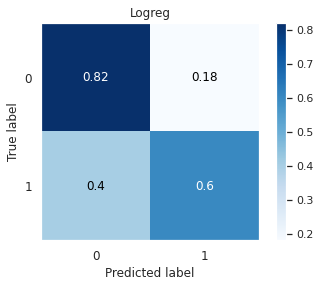

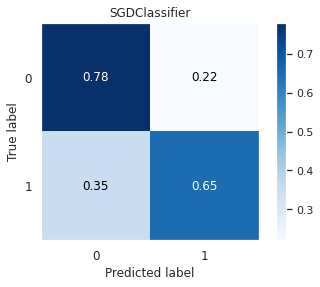

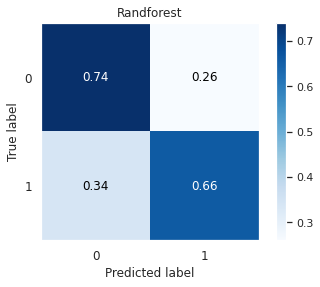

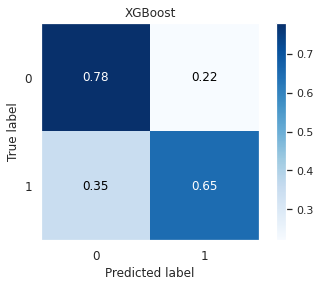

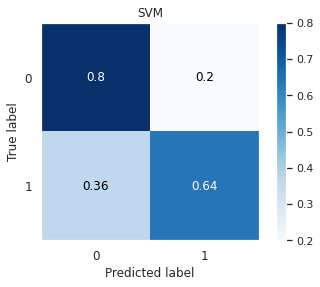

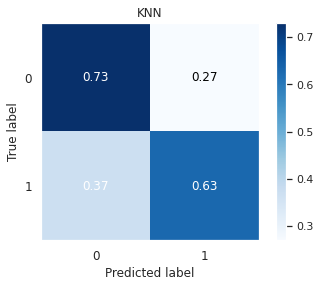

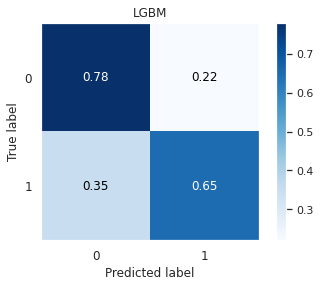

In [85]:
# Graph confing
plt.figure(figsize=(10, 10));

# Logistic Regression Classifier -> logreg_yhat
mt.plot_confusion_matrix( y_test, logreg_yhat, normalize=True).set_title('Logreg');

# Stochastic Gradient Descent Classifier (SGDClassifier) -> sgdc_yhat
mt.plot_confusion_matrix( y_test, sgdc_yhat, normalize=True).set_title('SGDClassifier');

# Random Forest Classifier -> randforest_yhat
mt.plot_confusion_matrix( y_test, randforest_yhat, normalize=True).set_title('Randforest');

# XGB Classifier -> xgb_yhat
mt.plot_confusion_matrix( y_test, xgboost_yhat, normalize=True).set_title('XGBoost');

# Suport Vector Machine Classifier -> svm_yhat
mt.plot_confusion_matrix( y_test, svm_yhat, normalize=True).set_title('SVM');

# K-Neareast Neighbors Classifier -> knn_yhat
mt.plot_confusion_matrix( y_test, knn_yhat, normalize=True).set_title('KNN');

# LGBM Classifier -> lgbm_yhat
mt.plot_confusion_matrix( y_test, lgbm_yhat, normalize=True).set_title('LGBM');

- The model that has the lower percentage of False negative (that means that the model predicted as not having cvd but actually the patient has cvd) is as follows:
    - Random Forest (0.34);
    - LGBM (0.35);
    - XGBoost (0.35);
    - SGD Classifier (0.35);
    - SVM (0.36);
    - KNN (0.37;
    - Logistic Regression (0.4).

### 6.9.2. ROC-AUC Curve

In [86]:
# ROC-AUC Score (x_test)

# Logistic Regression Classifier
logreg_cv_test = cross_val_predict(logreg, x_test, y_test, cv=5, method='decision_function')
logreg_roc_auc_test = roc_auc_score(y_test, logreg_cv_test)

# SGD Classifier
sgdc_cv_test = cross_val_predict(sgdc, x_test, y_test, cv=5, method='decision_function')
sgd_roc_auc_test = roc_auc_score(y_test, sgdc_cv_test)

# Random Forest Classifier
randforest_cv_test = cross_val_predict(randforest, x_test, y_test, cv=5)
randforest_roc_auc_test = roc_auc_score(y_test, randforest_cv_test)

# XGB Classifier -> xgb_cv
xgboost_cv_test = cross_val_predict(xgboost, x_test, y_test, cv=5);
xgboost_roc_auc_test = roc_auc_score(y_test, xgboost_cv_test);

# Suport Vector Machine Classifier -> svm_cv
svm_cv_test = cross_val_predict(svm, x_test, y_test, cv=5)
svm_roc_auc_test = roc_auc_score(y_test, svm_cv_test)

# K-Neareast Neighbors Classifier -> knn_cv
knn_cv_test = cross_val_predict(knn, x_test, y_test, cv=5)
knn_roc_auc_test = roc_auc_score(y_test, knn_cv_test)

# LGBM Classifier -> lgbm_cv
lgbm_cv_test = cross_val_predict(lgbm, x_test, y_test, cv=5)
lgbm_roc_auc_test = roc_auc_score(y_test, lgbm_cv_test)

In [87]:
# Compute False Positive Rate (fpr) and True Positive Rate (tpr)
# Logistic Regression Classifier -> logreg_cv
logreg_fpr, logreg_tpr, _ = roc_curve(y_test, sgdc_cv_test)

# Stochastic Gradient Descent Classifier (SGDClassifier) -> sgdc_cv
sgdc_fpr, sgdc_tpr, _ = roc_curve(y_test, sgdc_cv_test)

# Random Forest Classifier -> randforest_cv
randforest_fpr, randforest_tpr, _ = roc_curve(y_test, randforest_cv_test)

# XGB Classifier -> xgb_cv
xgboost_fpr, xgboost_tpr, _ = roc_curve(y_test, xgboost_cv_test)

# Suport Vector Machine Classifier -> svm_cv
svm_fpr, svm_tpr, _ = roc_curve(y_test, svm_cv_test)

# K-Neareast Neighbors Classifier -> knn_cv
knn_fpr, knn_tpr, _ = roc_curve(y_test, knn_cv_test)

# LGBM Classifier -> lgbm_cv
lgbm_fpr, lgbm_tpr, _ = roc_curve(y_test, lgbm_cv_test)

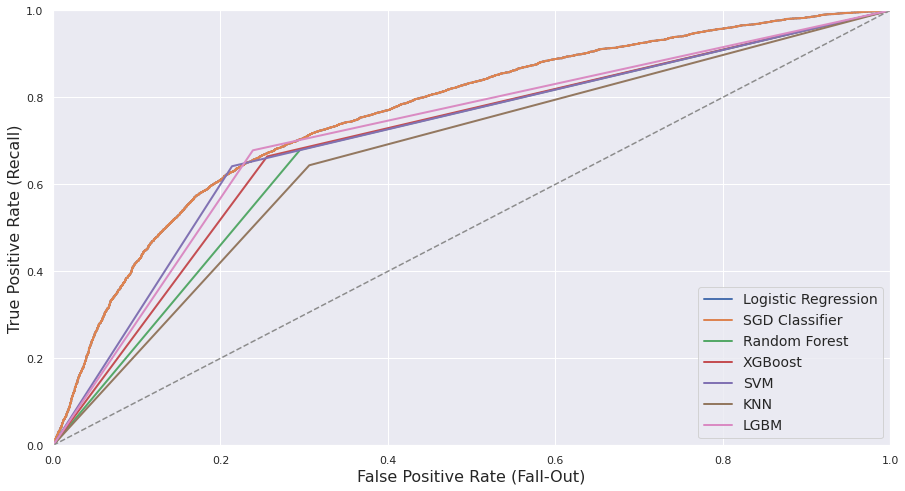

In [88]:
# plot ROC curve
plt.figure(figsize=(15,8));

plt.plot(logreg_fpr, logreg_tpr, label='Logistic Regression', linewidth=2);
plt.plot(sgdc_fpr, sgdc_tpr, label='SGD Classifier', linewidth=2);
plt.plot(randforest_fpr, randforest_tpr, label='Random Forest', linewidth=2);
plt.plot(xgboost_fpr, xgboost_tpr, label='XGBoost', linewidth=2);
plt.plot(svm_fpr, svm_tpr, label='SVM', linewidth=2);
plt.plot(knn_fpr, knn_tpr, label='KNN', linewidth=2);
plt.plot(lgbm_fpr, lgbm_tpr, label='LGBM', linewidth=2);

plt.plot([0, 1], [0, 1], '--');
plt.axis([0, 1, 0, 1]);
plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16);
plt.ylabel('True Positive Rate (Recall)', fontsize=16);
plt.legend(fontsize=14);


### 6.9.3. Model Selected To Be Implemented

Based on the comparison of the models performances, we are going to use the **LGBM** model.

# 7.0. CROSS-VALIDATION SCORING

In [89]:
# Merging train and test dataset to make the Cross-Validation
x_full = pd.concat([x_train, x_test])
y_full = pd.concat([y_train, y_test])

In [90]:
# Cross-Validation Metrics Performance

# Accuracy
lgbm_cv = cross_val_score(lgbm, x_full, y_full, cv=10, scoring='accuracy')
lgbm_cv_acc = pd.DataFrame(['Accuracy', (lgbm_cv.mean() * 100).round(3),(lgbm_cv.std() * 100).round(3)]).T

# Precision
lgbm_cv = cross_val_score(lgbm, x_full, y_full, cv=10, scoring='precision')
lgbm_cv_prec = pd.DataFrame(['Precision', (lgbm_cv.mean() * 100).round(3),(lgbm_cv.std() * 100).round(3)]).T

# Recall
lgbm_cv = cross_val_score(lgbm, x_full, y_full, cv=10, scoring='recall')
lgbm_cv_recall = pd.DataFrame(['Recall', (lgbm_cv.mean() * 100).round(3),(lgbm_cv.std() * 100).round(3)]).T

# F1-Score
lgbm_cv = cross_val_score(lgbm, x_full, y_full, cv=10, scoring='f1')
lgbm_cv_f1 = pd.DataFrame(['F1-Score', (lgbm_cv.mean() * 100).round(3),(lgbm_cv.std() * 100).round(3)]).T

# ROC-AUC
lgbm_cv = cross_val_score(lgbm, x_full, y_full, cv=10, scoring='roc_auc')
lgbm_cv_roc = pd.DataFrame(['ROC-AUC', (lgbm_cv.mean() * 100).round(3),(lgbm_cv.std() * 100).round(3)]).T

# Cross-Validation Performance
lgbm_cv_performance = pd.concat([lgbm_cv_acc, lgbm_cv_prec, lgbm_cv_recall, lgbm_cv_f1, lgbm_cv_roc])
lgbm_cv_performance.columns = ['Metric', 'Mean', 'std']
lgbm_cv_performance

,Metric,Mean,std
0,Accuracy,73.279,0.85
0,Precision,75.479,0.927
0,Recall,68.091,1.279
0,F1-Score,71.59,0.995
0,ROC-AUC,79.783,1


# 8.0. HYPERPARAMETER FINE TUNNING

## 8.1. Random Search

In [91]:
# Setting Hyperparameters values
parameters = {'num_leaves': 2 ** np.arange(2, 12, 2),
              'max_depth': np.arange(0, 12, 2),
              'n_estimators': np.arange(10, 105, 15),
              'min_data_in_leaf': np.arange(100, 1050, 50),
              'learning_rate': np.linspace(0.001, 0.6, 15),
              'colsample_bytree': np.linspace(0.1, 1, 5),
              'subsample': np.linspace(0.25, 1, 15)}

# Setting MAX_EVAL
MAX_EVAL = 5

In [ ]:
grid_lgbm = GridSearchCV(estimator=lgbm, param_grid=parameters, cv=2)
grid_lgbm.fit(x_full, y_full)

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGB

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGB

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGB

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGB

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGB

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGB

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGB

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGB

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGB

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGB

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGB

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGB

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGB

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGB

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGB

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGB

[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGB

[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGB

[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGB

[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGB

[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGB

[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGB

[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGB

[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGB

[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGB

[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGB

[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGB

[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGB

[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGB

[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGB

[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGB

[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGB

[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGB

[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGB

[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGB

[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGB

[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGB

[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGB

[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGB

[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGB

[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGB

[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGB

[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGB

[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGB

[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGB

[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGB

[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGB

[LightGBM] [Warning] min_data_in_leaf is set=250, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=250
[LightGBM] [Warning] min_data_in_leaf is set=250, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=250
[LightGBM] [Warning] min_data_in_leaf is set=250, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=250
[LightGBM] [Warning] min_data_in_leaf is set=250, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=250
[LightGBM] [Warning] min_data_in_leaf is set=250, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=250
[LightGBM] [Warning] min_data_in_leaf is set=250, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=250
[LightGBM] [Warning] min_data_in_leaf is set=250, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=250
[LightGBM] [Warning] min_data_in_leaf is set=250, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=250
[LightGB

[LightGBM] [Warning] min_data_in_leaf is set=250, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=250
[LightGBM] [Warning] min_data_in_leaf is set=250, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=250
[LightGBM] [Warning] min_data_in_leaf is set=250, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=250
[LightGBM] [Warning] min_data_in_leaf is set=250, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=250
[LightGBM] [Warning] min_data_in_leaf is set=250, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=250
[LightGBM] [Warning] min_data_in_leaf is set=250, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=250
[LightGBM] [Warning] min_data_in_leaf is set=250, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=250
[LightGBM] [Warning] min_data_in_leaf is set=250, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=250
[LightGB

[LightGBM] [Warning] min_data_in_leaf is set=250, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=250
[LightGBM] [Warning] min_data_in_leaf is set=250, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=250
[LightGBM] [Warning] min_data_in_leaf is set=250, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=250
[LightGBM] [Warning] min_data_in_leaf is set=250, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=250
[LightGBM] [Warning] min_data_in_leaf is set=250, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=250
[LightGBM] [Warning] min_data_in_leaf is set=250, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=250
[LightGBM] [Warning] min_data_in_leaf is set=250, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=250
[LightGBM] [Warning] min_data_in_leaf is set=250, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=250
[LightGB

[LightGBM] [Warning] min_data_in_leaf is set=250, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=250
[LightGBM] [Warning] min_data_in_leaf is set=250, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=250
[LightGBM] [Warning] min_data_in_leaf is set=250, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=250
[LightGBM] [Warning] min_data_in_leaf is set=250, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=250
[LightGBM] [Warning] min_data_in_leaf is set=250, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=250
[LightGBM] [Warning] min_data_in_leaf is set=250, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=250
[LightGBM] [Warning] min_data_in_leaf is set=250, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=250
[LightGBM] [Warning] min_data_in_leaf is set=250, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=250
[LightGB

[LightGBM] [Warning] min_data_in_leaf is set=250, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=250
[LightGBM] [Warning] min_data_in_leaf is set=250, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=250
[LightGBM] [Warning] min_data_in_leaf is set=250, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=250
[LightGBM] [Warning] min_data_in_leaf is set=250, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=250
[LightGBM] [Warning] min_data_in_leaf is set=250, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=250
[LightGBM] [Warning] min_data_in_leaf is set=250, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=250
[LightGBM] [Warning] min_data_in_leaf is set=250, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=250
[LightGBM] [Warning] min_data_in_leaf is set=250, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=250
[LightGB

[LightGBM] [Warning] min_data_in_leaf is set=250, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=250
[LightGBM] [Warning] min_data_in_leaf is set=250, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=250
[LightGBM] [Warning] min_data_in_leaf is set=250, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=250
[LightGBM] [Warning] min_data_in_leaf is set=250, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=250
[LightGBM] [Warning] min_data_in_leaf is set=250, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=250
[LightGBM] [Warning] min_data_in_leaf is set=250, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=250
[LightGBM] [Warning] min_data_in_leaf is set=250, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=250
[LightGBM] [Warning] min_data_in_leaf is set=250, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=250
[LightGB

In [ ]:
print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",grid_lgbm.best_estimator_)
print("\n The best score across ALL searched params:\n",grid_lgbm.best_score_)
print("\n The best parameters across ALL searched params:\n",grid_lgbm.best_params_)